# Multivariate Time Series Forecast Using Vector Autoregression
### multivariate time series–time series which has more than one time-dependent variable.

![image.png](https://miro.medium.com/v2/resize:fit:720/format:webp/1*WrKW5zBbrRmRUbmSL67GMQ.png)


image from https://vannguyen-8073.medium.com/using-lstm-multivariate-and-univariate-in-order-to-predict-stock-market-39e8f6551c93

## THEORY:

#### Vectored Auto Regression could have multiple possible combinations like we had it for ARIMA.

### VAR Model (Vector Autoregression)
- Description: A VAR model captures the linear interdependencies among multiple time series.
- Components: Each variable is modeled as a linear function of its own past values (lags) and the past values of all other variables in the system.

### VARMA Model (Vector Autoregressive Moving Average)
- Description: A VARMA model extends the VAR model by including moving average (MA) terms.
- Components: Each variable is modeled as a linear function of its own past values, the past values of all other variables, and past error terms (residuals).

### VARIMA Model (Vector Autoregressive Integrated Moving Average)
- Description: A VARIMA model is used when the time series data are non-stationary and need to be differenced to achieve stationarity.
- Components: Combines the features of VAR and ARIMA models. It includes differencing to make the data stationary, autoregressive terms, and moving average terms.

#### Further reading:

##### https://www.geeksforgeeks.org/vector-autoregression-var-for-multivariate-time-series/
##### https://medium.com/geekculture/vector-auto-regressive-var-models-for-multivariate-time-series-forecasting-106bb6f74add
##### https://medium.com/intuition/statistics-multivariate-time-series-analysis-vma-var-varma-3cb1fbac5553
##### https://pub.towardsai.net/unleash-the-power-of-multivariate-time-series-forecasting-with-vector-autoregression-var-models-7e7c94fc0ba4
##### https://medium.com/@kirudang/multivariable-time-series-approach-guide-for-time-series-with-multiple-predictors-ac89c5893370

In [2]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [3]:
import numpy as np
import pandas as pd

#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error, r2_score

from statsmodels.tsa.stattools import acf, pacf, q_stat, adfuller, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import VAR

from scipy.stats import probplot, moment
import time

In [4]:
import platform
print(f"Python version: {platform.python_version()}")
print(f"numpy version: {np.__version__}")
print(f"panda version: {pd.__version__}")
print(f"seaborn version: {sns.__version__}")
import matplotlib
print(f"matplotlib version: {matplotlib.__version__}")
import sklearn 
print(f"sklearn version: {sklearn. __version__}")
import statsmodels
print(f"statsmodel version: {statsmodels.__version__}")
import scipy
print(f"scipy version: {scipy.__version__}")

Python version: 3.10.14
numpy version: 1.26.4
panda version: 2.2.1
seaborn version: 0.13.2
matplotlib version: 3.7.5
sklearn version: 1.4.1.post1
statsmodel version: 0.14.1
scipy version: 1.14.1


In [5]:
# Define a Function to Format the Time: This function will convert the elapsed time into hours, minutes, and seconds.
def format_time(seconds):
    hours, rem = divmod(seconds, 3600)
    minutes, seconds = divmod(rem, 60)
    return f"{int(hours)}h {int(minutes)}m {seconds:.2f}s"

In [6]:
# dataset from https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction
df =  pd.read_csv('energydata_complete.csv', delimiter=',')

In [7]:
df.head()

date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  
0    92.0   7.000000   63.000000        5.3  13.275433  13.275433  
1    92.0   6.666667   59.166667        5.2  18.606195  18.606195  
2    92.0   6.333333   55.333333        5.1  28.642668  28.642668  
3    92.0   6.000000   51.500000        5.0  45.410389  45.410389  
4    92.0   5.666667   47.666667        4.9  10.084097  10.084097  

[5 rows x 29 columns]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

#### Attribute Information: The energy data was logged every 10 minutes for about 4.5 months

    date time year-month-day hour:minute:second 
    Appliances, energy use in Wh
    lights, energy use of light fixtures in the house in Wh
    T1, Temperature in kitchen area, in Celsius
    RH_1, Humidity in kitchen area, in %
    T2, Temperature in living room area, in Celsius
    RH_2, Humidity in living room area, in %
    T3, Temperature in laundry room area
    RH_3, Humidity in laundry room area, in %
    T4, Temperature in office room, in Celsius
    RH_4, Humidity in office room, in %
    T5, Temperature in bathroom, in Celsius
    RH_5, Humidity in bathroom, in %
    T6, Temperature outside the building (north side), in Celsius
    RH_6, Humidity outside the building (north side), in %
    T7, Temperature in ironing room , in Celsius
    RH_7, Humidity in ironing room, in %
    T8, Temperature in teenager room 2, in Celsius
    RH_8, Humidity in teenager room 2, in %
    T9, Temperature in parents room, in Celsius
    RH_9, Humidity in parents room, in %
    T_out, Temperature outside (from Chievres weather station), in Celsius
    Pressure (from Chievres weather station), in mm Hg
    RH_out, Humidity outside (from Chievres weather station), in %
    Wind speed (from Chievres weather station), in m/s
    Visibility (from Chievres weather station), in km
    Tdewpoint (from Chievres weather station), Â°C
    rv1, Random variable 1, nondimensional
    rv2, Random variable 2, nondimensional

In [9]:
df.isna().sum(axis=0) # check any NA same as df.isnull().sum()

date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

In [10]:
df['date'] = pd.to_datetime(df['date'], format='mixed')  # change type to datetime

In [11]:
df['date']

0       2016-01-11 17:00:00
1       2016-01-11 17:10:00
2       2016-01-11 17:20:00
3       2016-01-11 17:30:00
4       2016-01-11 17:40:00
                ...        
19730   2016-05-27 17:20:00
19731   2016-05-27 17:30:00
19732   2016-05-27 17:40:00
19733   2016-05-27 17:50:00
19734   2016-05-27 18:00:00
Name: date, Length: 19735, dtype: datetime64[ns]

In [12]:
sub_df = df.set_index('date')[['Appliances', 'lights','T_out', 'RH_out', 'Press_mm_hg', 'Windspeed', 'Visibility', 'Tdewpoint']]

In [13]:
sub_df.tail()

Appliances  lights      T_out     RH_out  Press_mm_hg  \
date                                                                         
2016-05-27 17:20:00         100       0  22.733333  55.666667        755.2   
2016-05-27 17:30:00          90       0  22.600000  56.000000        755.2   
2016-05-27 17:40:00         270      10  22.466667  56.333333        755.2   
2016-05-27 17:50:00         420      10  22.333333  56.666667        755.2   
2016-05-27 18:00:00         430      10  22.200000  57.000000        755.2   

                     Windspeed  Visibility  Tdewpoint  
date                                                   
2016-05-27 17:20:00   3.333333   23.666667  13.333333  
2016-05-27 17:30:00   3.500000   24.500000  13.300000  
2016-05-27 17:40:00   3.666667   25.333333  13.266667  
2016-05-27 17:50:00   3.833333   26.166667  13.233333  
2016-05-27 18:00:00   4.000000   27.000000  13.200000

### Exploratory Data Analysis

In [14]:
sub_df.describe()

Appliances        lights         T_out        RH_out   Press_mm_hg  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      97.694958      3.801875      7.411665     79.750418    755.522602   
std      102.524891      7.935988      5.317409     14.901088      7.399441   
min       10.000000      0.000000     -5.000000     24.000000    729.300000   
25%       50.000000      0.000000      3.666667     70.333333    750.933333   
50%       60.000000      0.000000      6.916667     83.666667    756.100000   
75%      100.000000      0.000000     10.408333     91.666667    760.933333   
max     1080.000000     70.000000     26.100000    100.000000    772.300000   

          Windspeed    Visibility     Tdewpoint  
count  19735.000000  19735.000000  19735.000000  
mean       4.039752     38.330834      3.760707  
std        2.451221     11.794719      4.194648  
min        0.000000      1.000000     -6.600000  
25%        2.000000     29.000000      0.900000  
50%        3.666667     40.000000      3.433333  
75%        5.500000     40.000000      6.566667  
max       14.000000     66.000000     15.500000

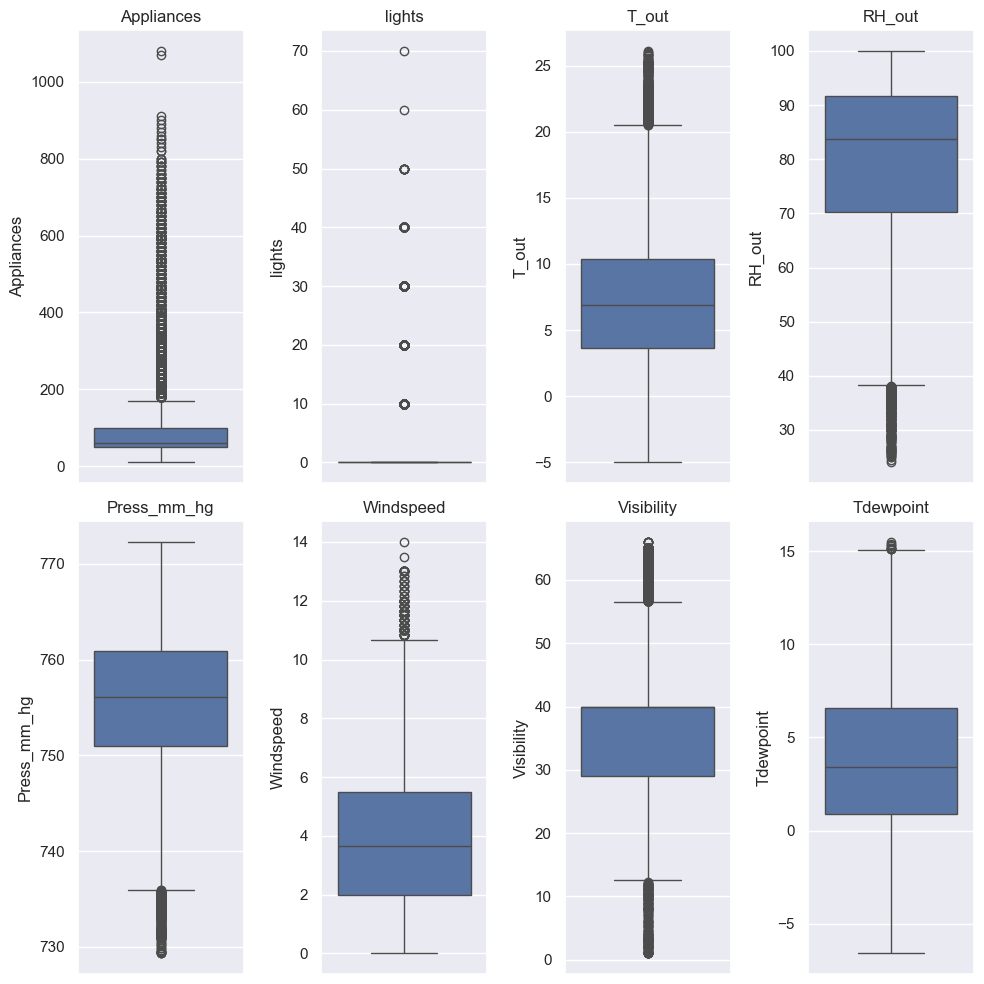

In [15]:
# Create a 2x4 grid of boxplots
fig, axes = plt.subplots(2, 4, figsize=(10, 10))

n_rows = 2
n_cols = 4
col_num = 0

for i in range(n_rows):
    for j in range(n_cols):
        sns.boxplot(ax=axes[i, j], data=sub_df.iloc[:, col_num])
        axes[i, j].set_title(sub_df.columns[col_num])
        col_num += 1

plt.tight_layout()
plt.show()

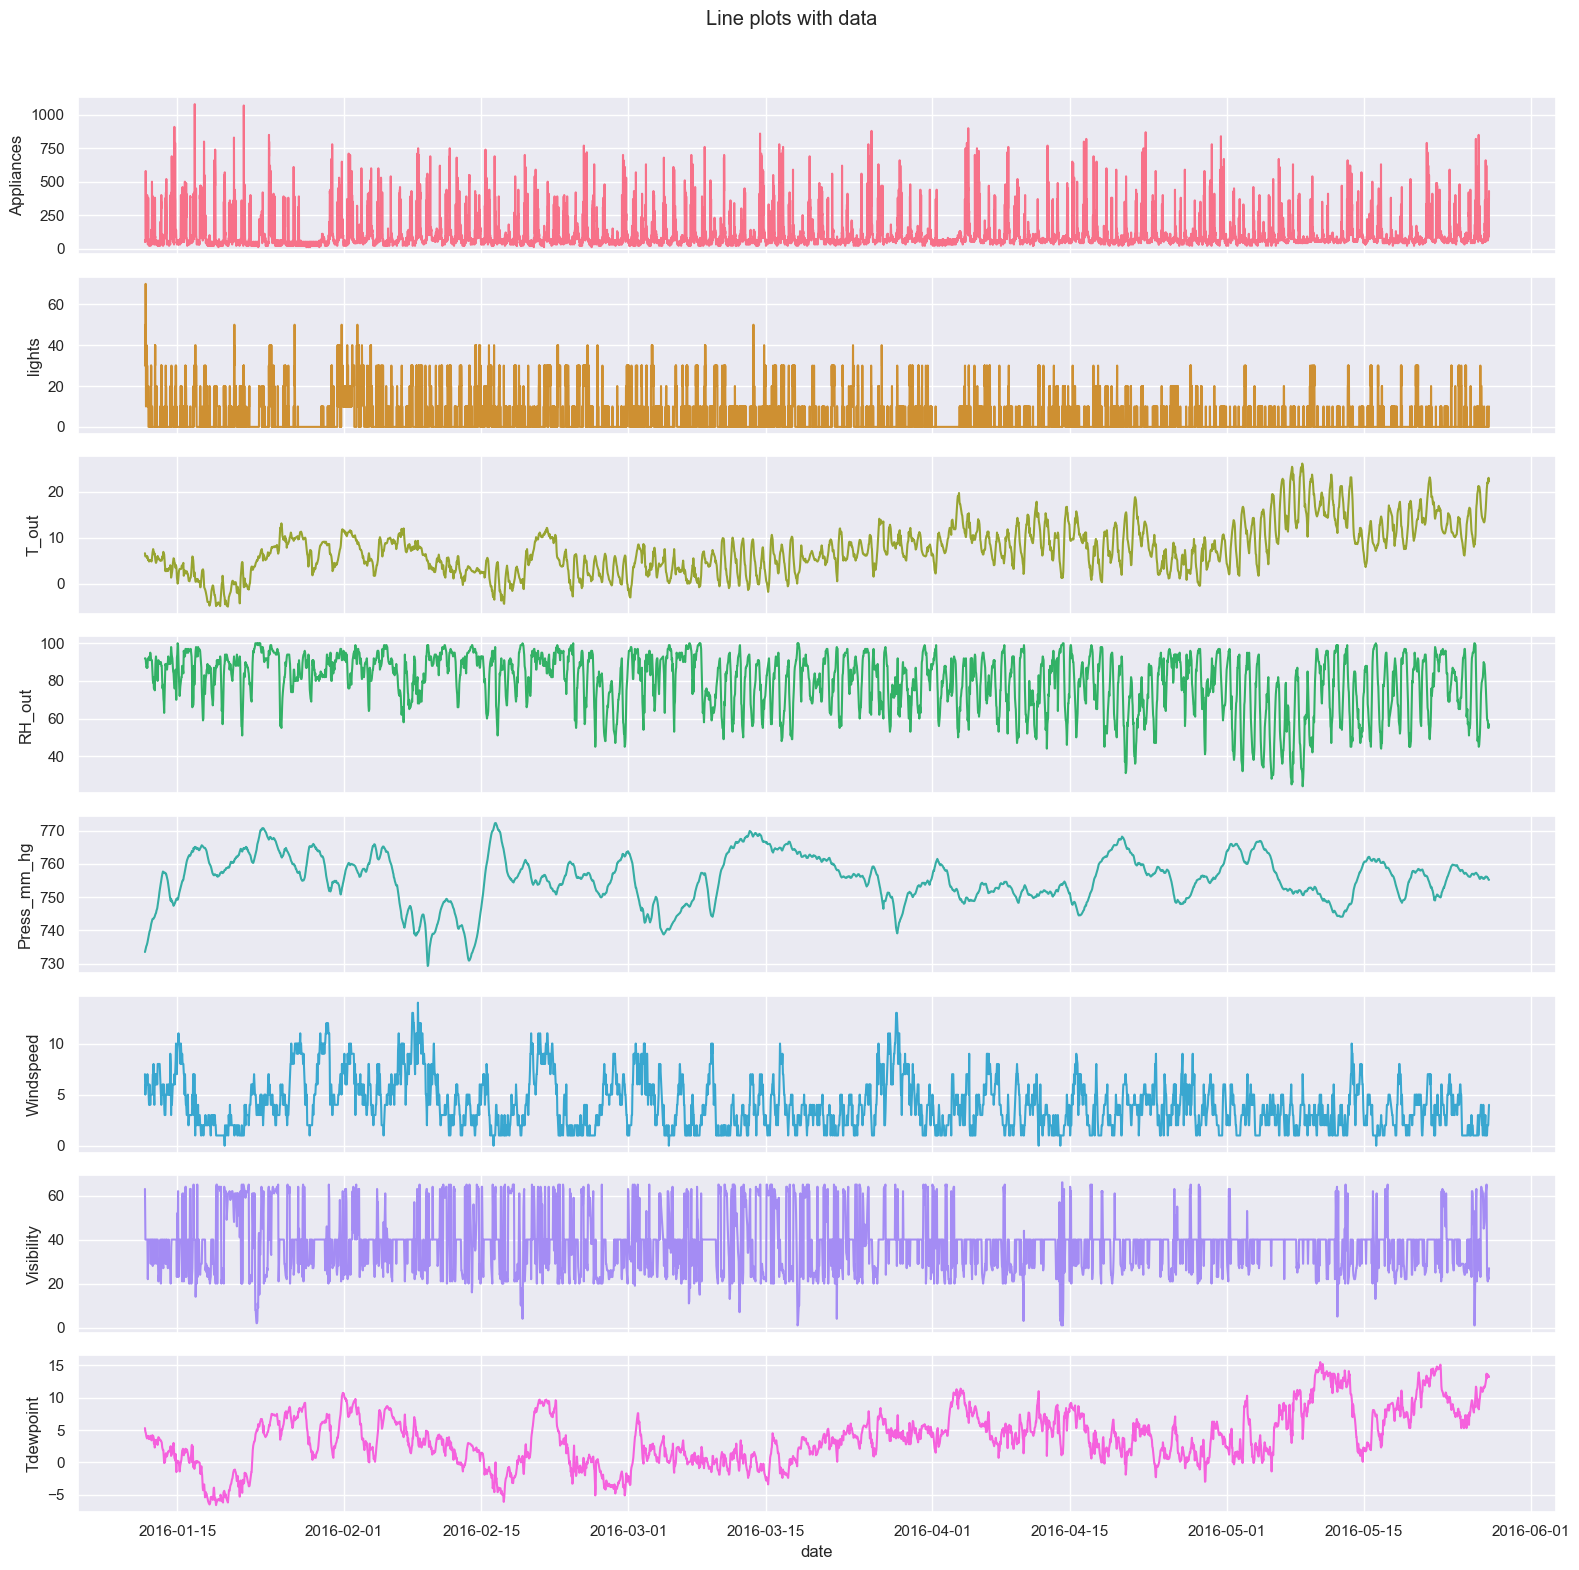

In [16]:
# Create subplots
fig, axes = plt.subplots(8,1, figsize=(16, 16) , sharex=True)
# Set the main title 
fig.suptitle('Line plots with data')

# Define a color palette
palette = sns.color_palette("husl", 8)

# Create line plots
for i, col in enumerate(list(sub_df.columns)):
    sns.lineplot(ax=axes[i], data=sub_df, x='date', y=col, color=palette[i])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

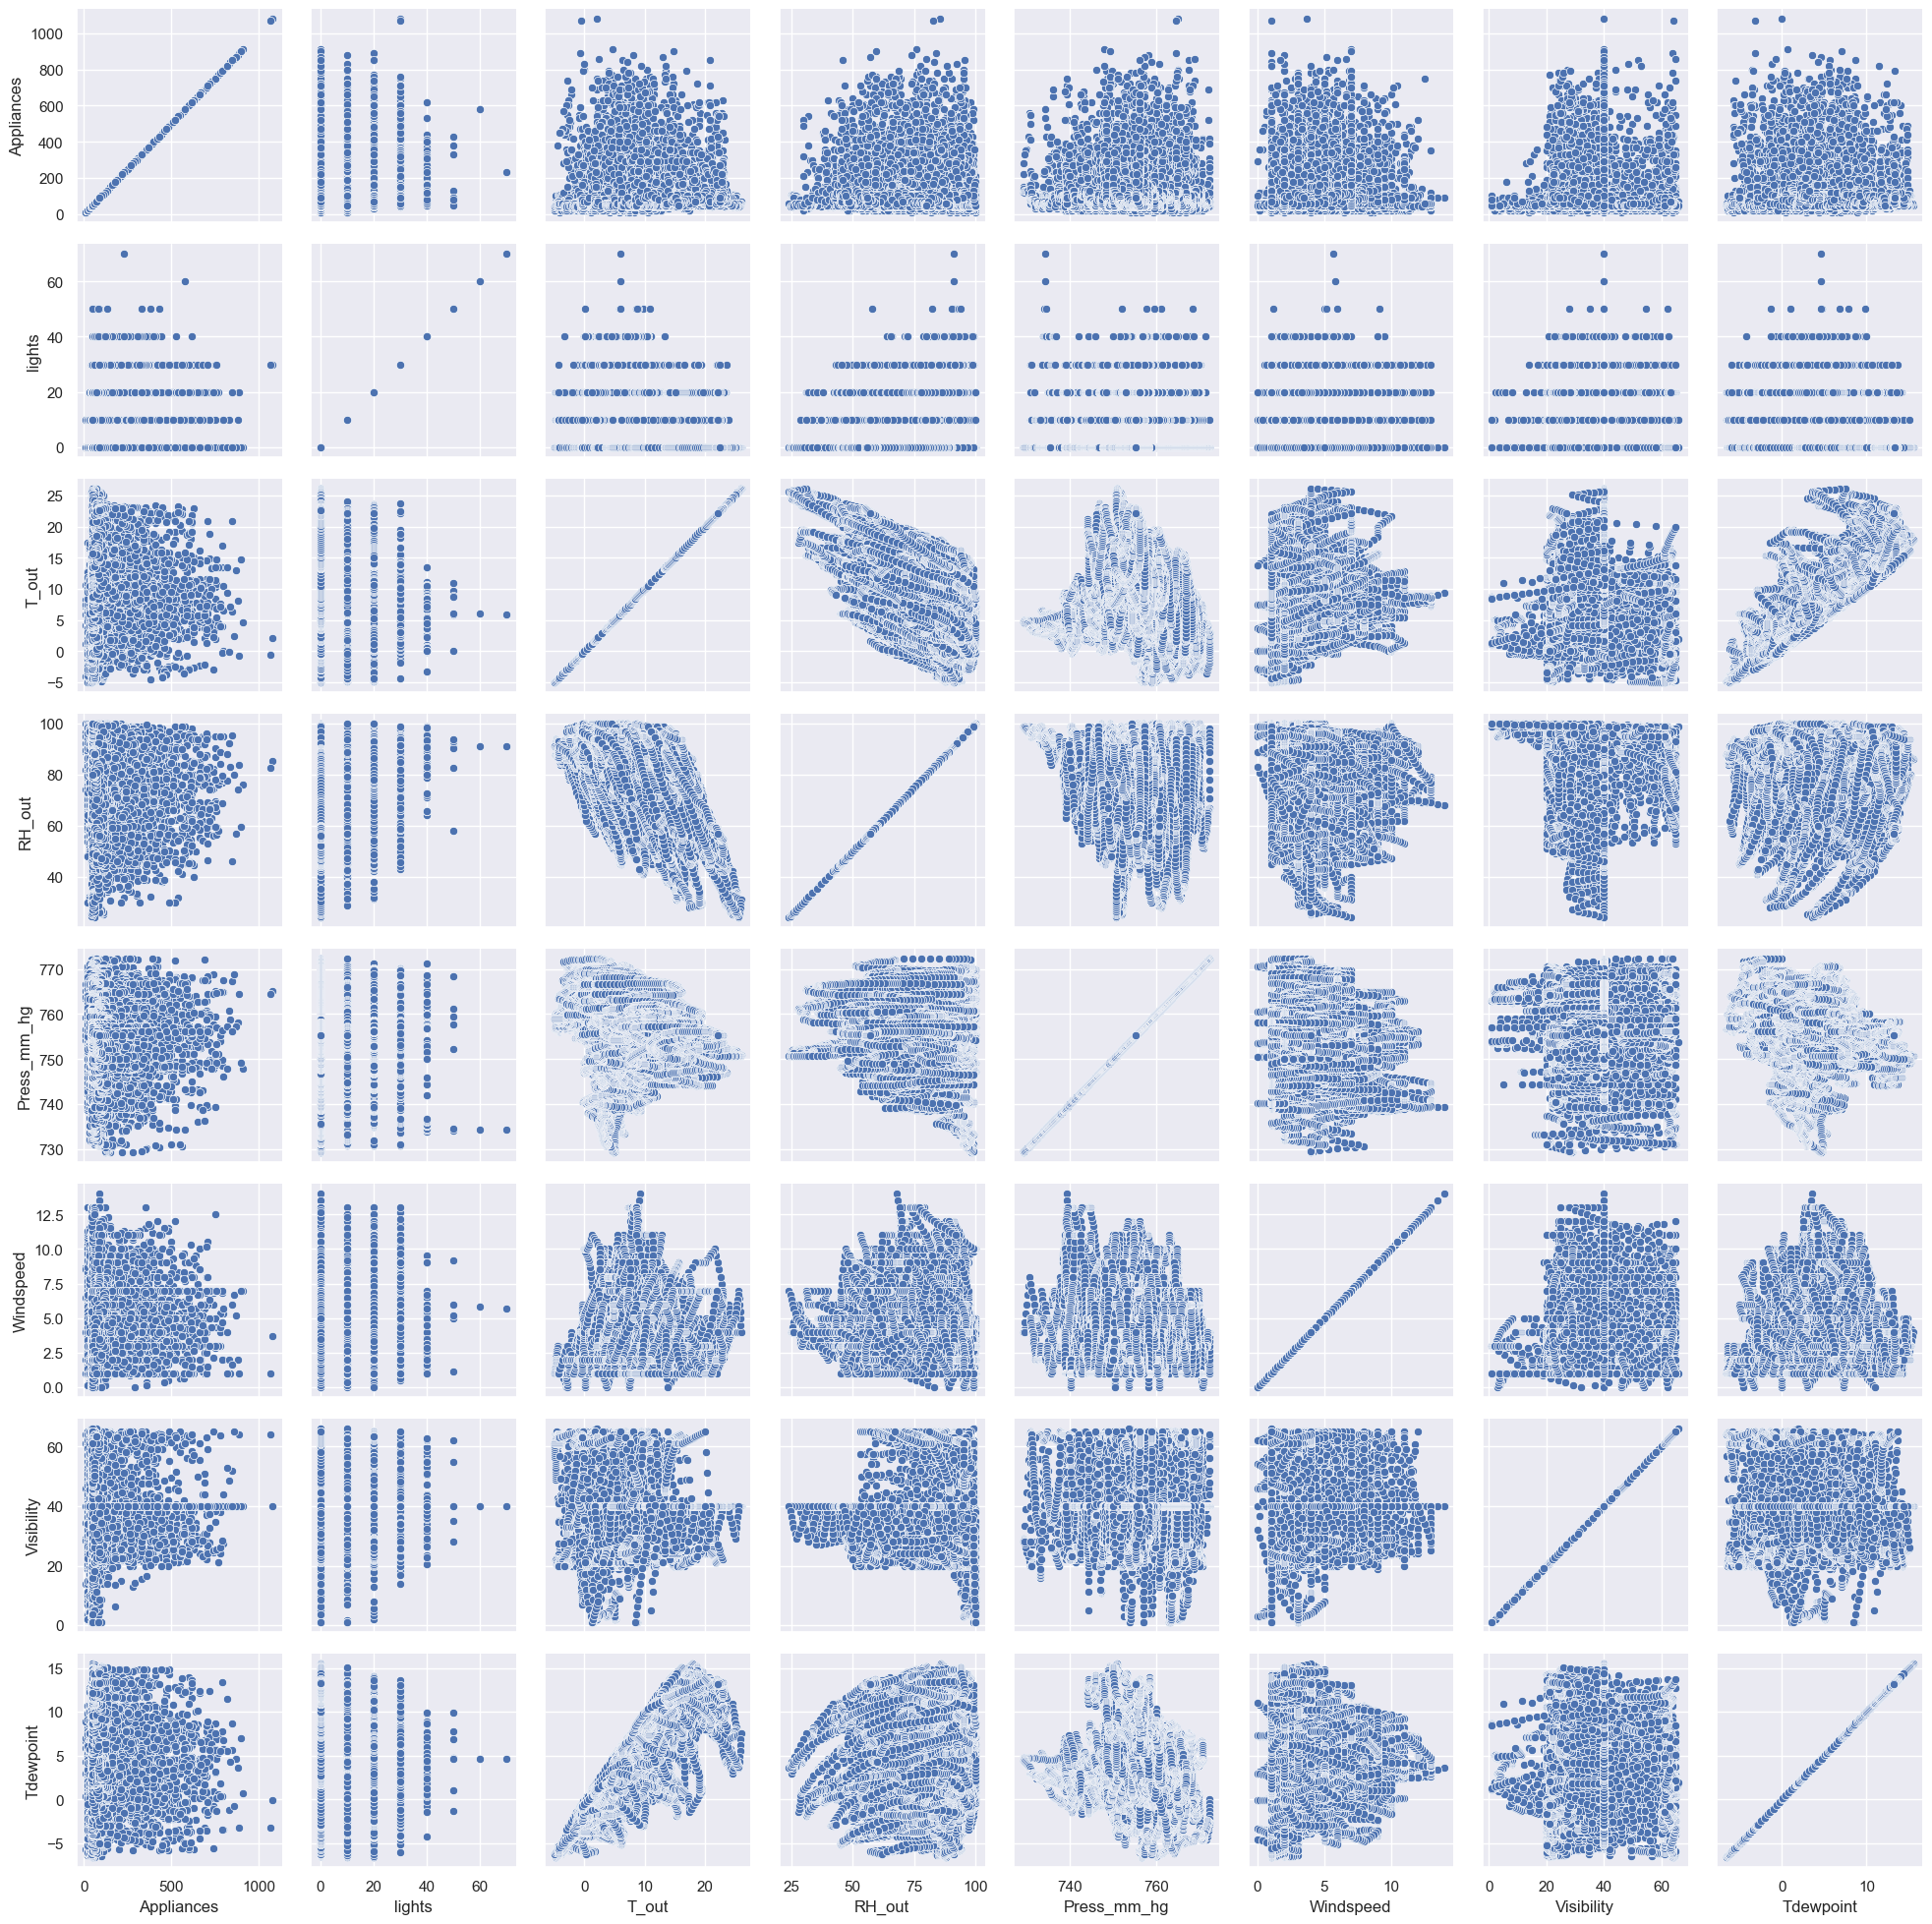

In [17]:
g = sns.PairGrid(sub_df)
g.map(sns.scatterplot)

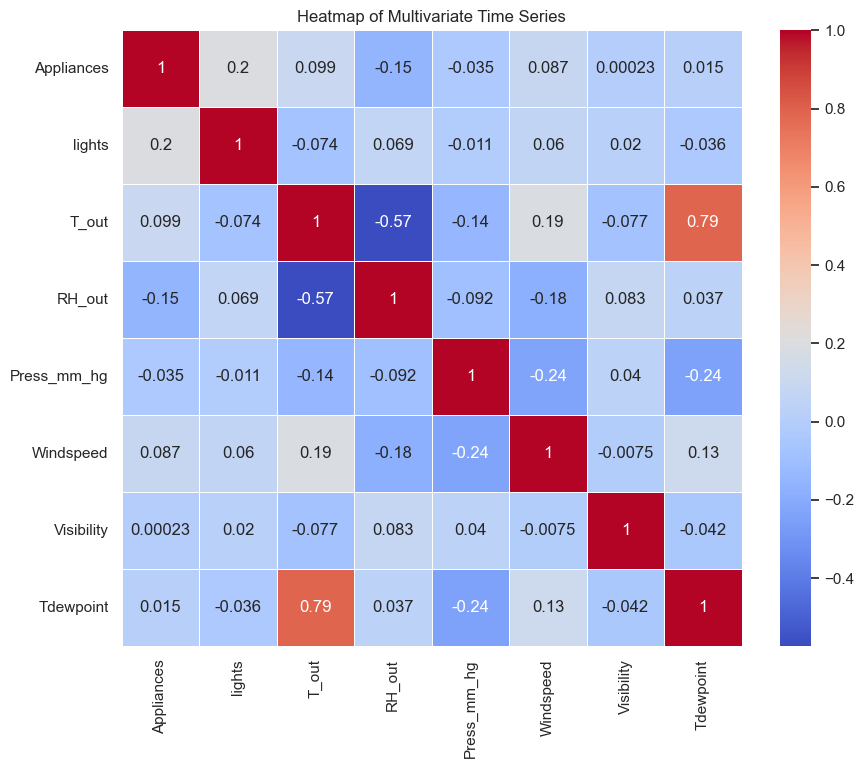

In [18]:
# Compute the correlation matrix
corr = sub_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Multivariate Time Series')
plt.show()

#### Tdewpoint and T_out exhibit a strong positive correlation, while RH_out and T_out show a moderate negative correlation.

### Check for Stationarity

In [19]:
# Define function for Stationary check
# code from https://www.kaggle.com/code/jurk06/auto-arima-on-multivariate-time-series
def check_stationarity(series, signif=0.05, name='', verbose=False):
    
    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [20]:
# ADF Test on each column
for name, column in sub_df.items():
    check_stationarity(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Appliances" 
    -----------------------------------------------
ADF Statistic: -21.616378
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "lights" 
    -----------------------------------------------
ADF Statistic: -21.575876
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "T_out" 
    -----------------------------------------------
ADF Statistic: -7.376707
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "RH_out" 
    -----------------------------------------------
ADF Statistic: -15.609493
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


    Augmented Dickey-Fuller Test on "Press_mm_hg" 
    -----------------------------------------------
ADF Statistic: -5.717286
p-value: 0.000001
Critical Values:

In [21]:
# code from https://phdinds-aim.github.io/time_series_handbook/03_VectorAutoregressiveModels/03_VectorAutoregressiveMethods.html

test_stat, p_val = [], []
cv_1pct, cv_5pct, cv_10pct = [], [], []
for c in sub_df.columns: 
    adf_res = adfuller(sub_df[c].dropna())
    test_stat.append(adf_res[0])
    p_val.append(adf_res[1])
    cv_1pct.append(adf_res[4]['1%'])
    cv_5pct.append(adf_res[4]['5%'])
    cv_10pct.append(adf_res[4]['10%'])
adf_res_df = pd.DataFrame({'Test statistic': test_stat, 
                           'p-value': p_val, 
                           'Critical value - 1%': cv_1pct,
                           'Critical value - 5%': cv_5pct,
                           'Critical value - 10%': cv_10pct}, 
                         index=sub_df.columns).T
adf_res_df.round(4)

Appliances   lights   T_out   RH_out  Press_mm_hg  \
Test statistic          -21.6164 -21.5759 -7.3767 -15.6095      -5.7173   
p-value                   0.0000   0.0000  0.0000   0.0000       0.0000   
Critical value - 1%      -3.4307  -3.4307 -3.4307  -3.4307      -3.4307   
Critical value - 5%      -2.8617  -2.8617 -2.8617  -2.8617      -2.8617   
Critical value - 10%     -2.5668  -2.5668 -2.5668  -2.5668      -2.5668   

                      Windspeed  Visibility  Tdewpoint  
Test statistic          -9.9432    -16.2291    -4.4440  
p-value                  0.0000      0.0000     0.0002  
Critical value - 1%     -3.4307     -3.4307    -3.4307  
Critical value - 5%     -2.8617     -2.8617    -2.8617  
Critical value - 10%    -2.5668     -2.5668    -2.5668

#### All are Stationary

#### When variables are stationary, their statistical properties such as mean and variance do not change over time. This implies that they revert to a long-term mean and have a constant variance.

In [22]:
# Create the Decomposition Function
def decompose_and_plot(df, column, model='additive', period=12):
    """
    Decompose and plot the time series for a given column.
    
    Parameters:
    df (DataFrame): The DataFrame containing the time series data.
    column (str): The column name to decompose.
    model (str): The type of decomposition ('additive' or 'multiplicative').
    period (int): The period of the seasonality.
    """
    result = seasonal_decompose(df[column], model=model, period=period)
    
    # Plot the decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f'Seasonal Decomposition of {column}', fontsize=16)
    
    result.observed.plot(ax=ax1)
    ax1.set_ylabel('Observed')
    
    result.trend.plot(ax=ax2)
    ax2.set_ylabel('Trend')
    
    result.seasonal.plot(ax=ax3)
    ax3.set_ylabel('Seasonal')
    
    result.resid.plot(ax=ax4)
    ax4.set_ylabel('Residual')
    plt.show()

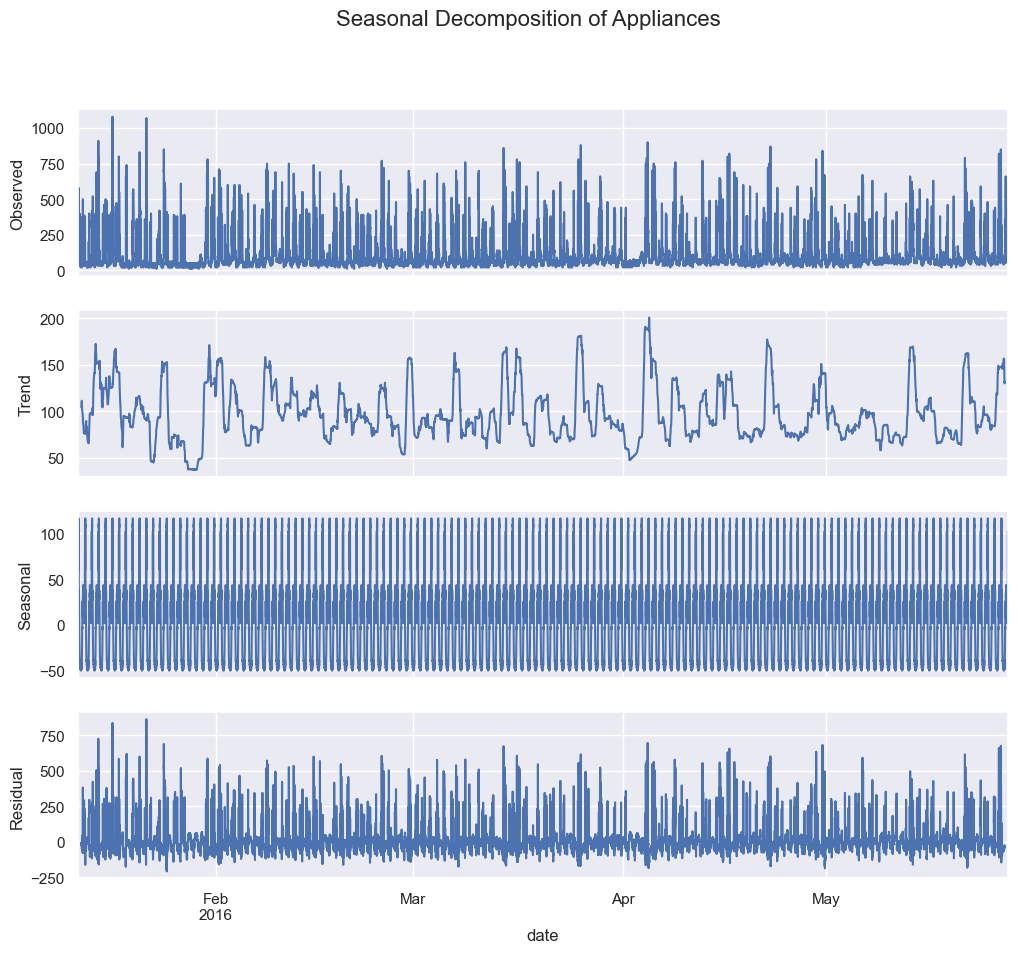

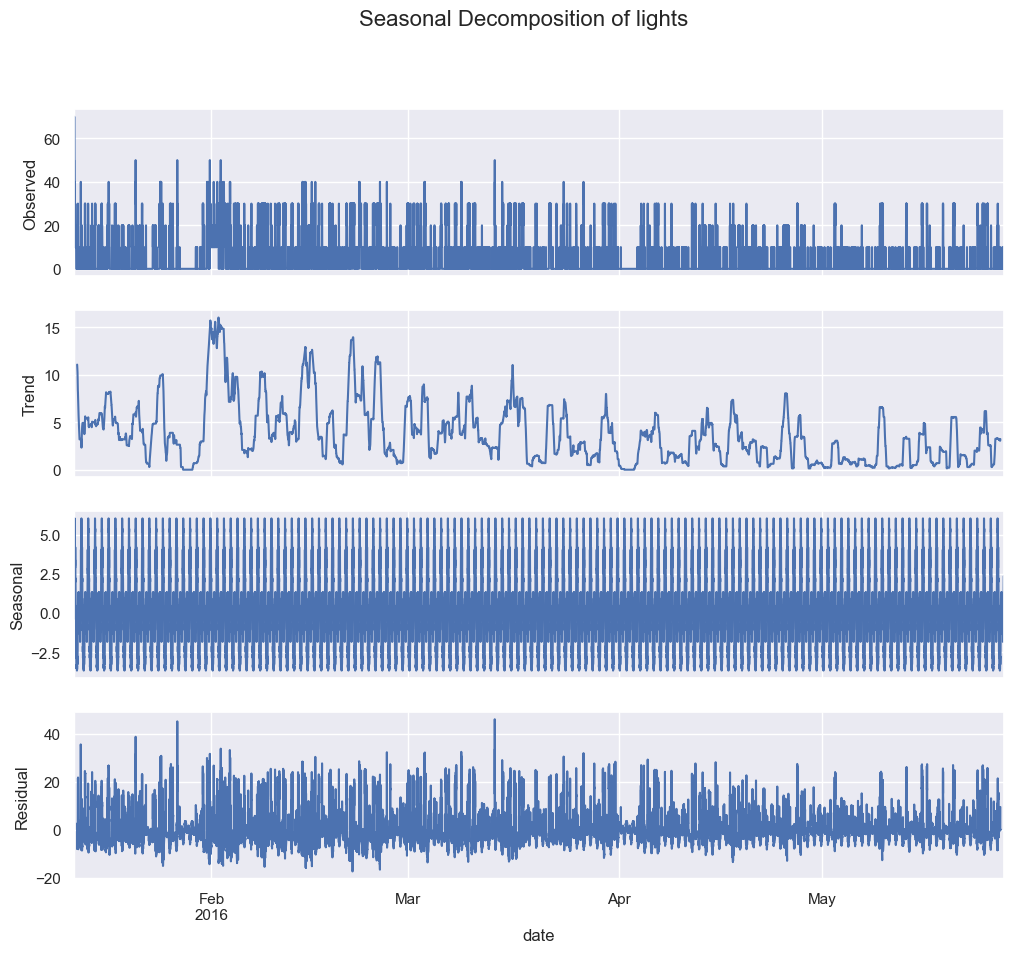

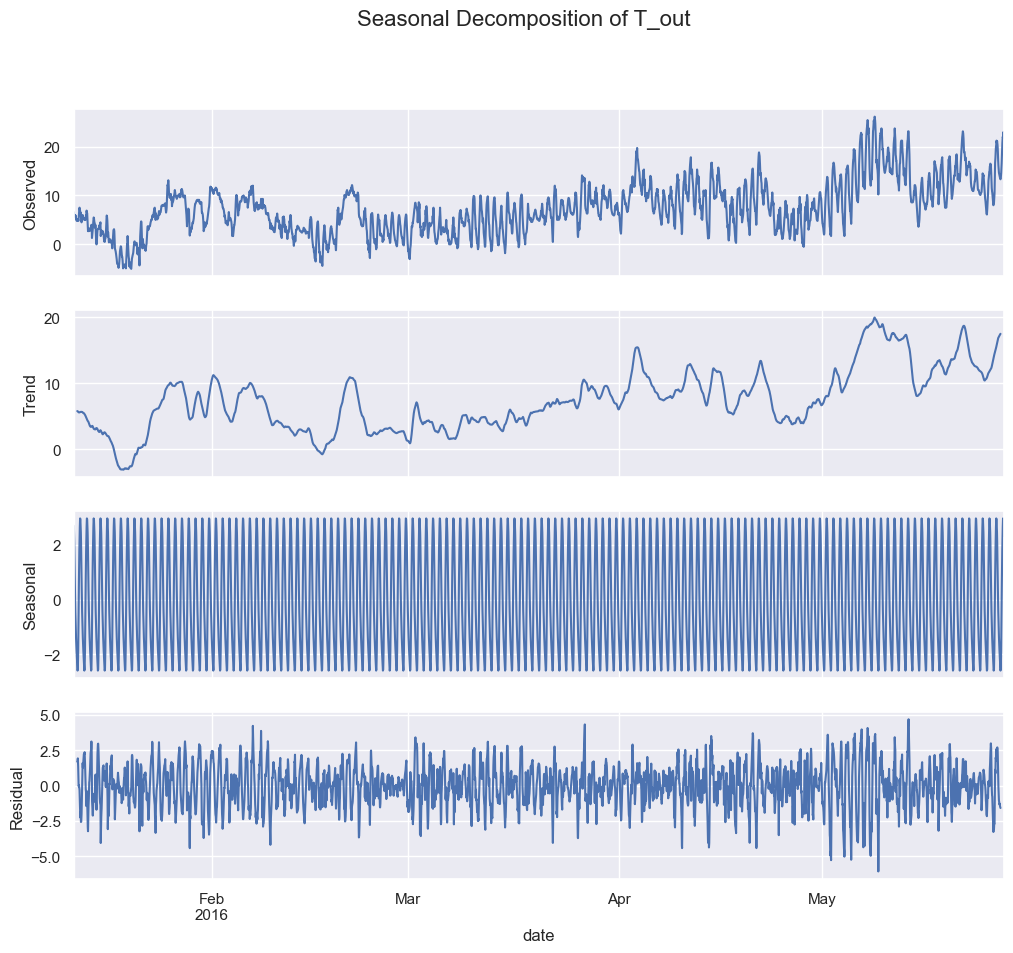

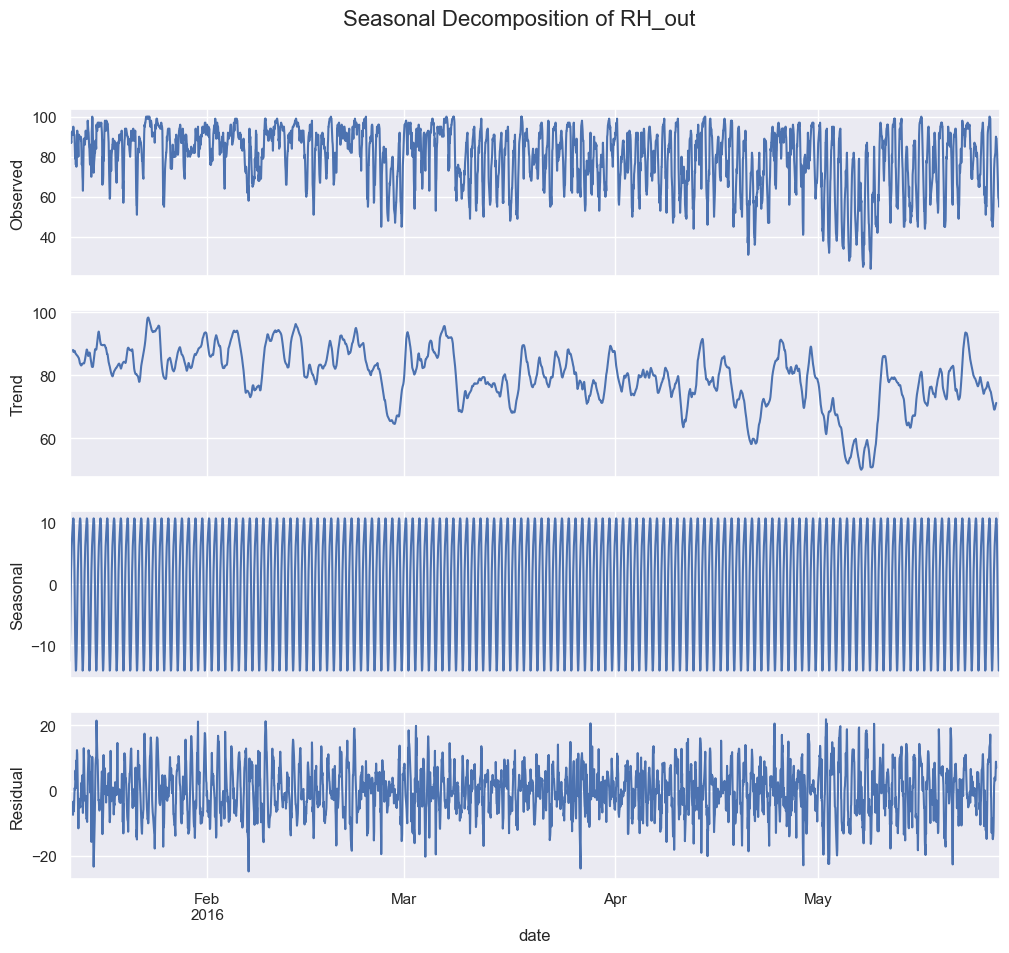

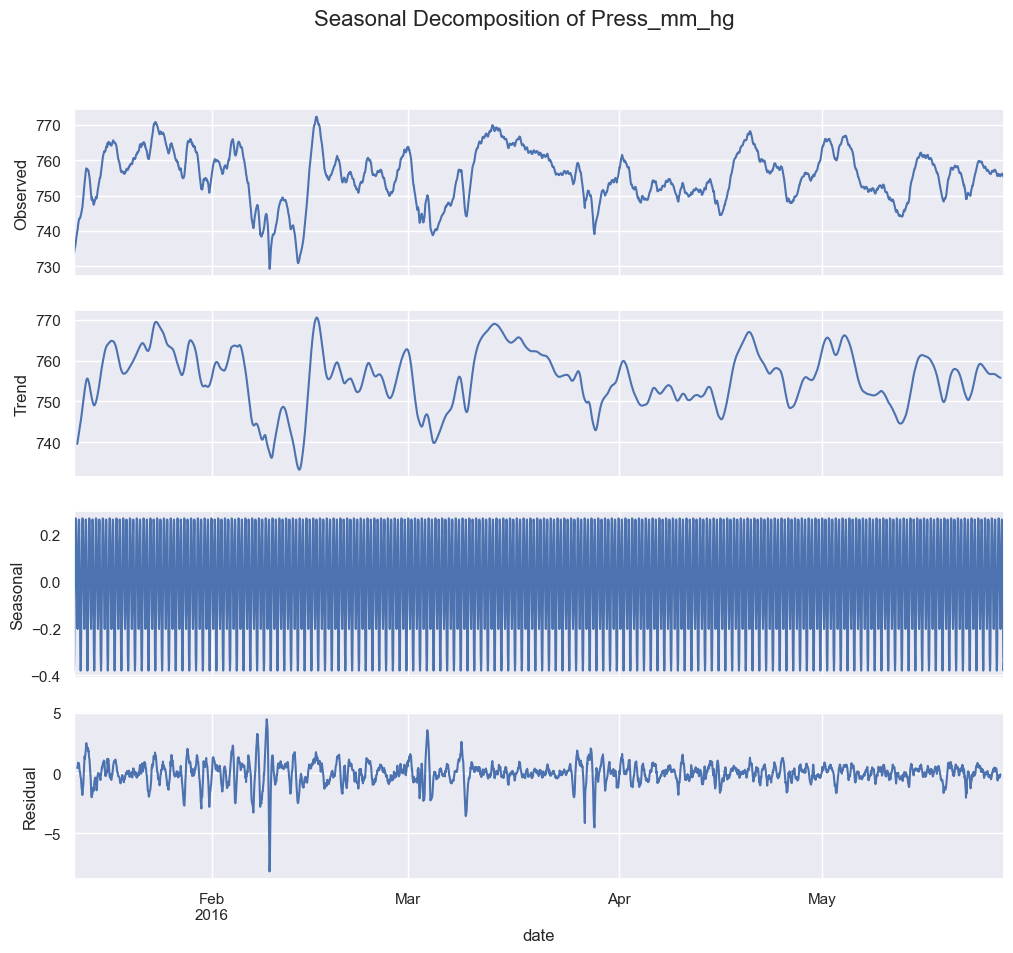

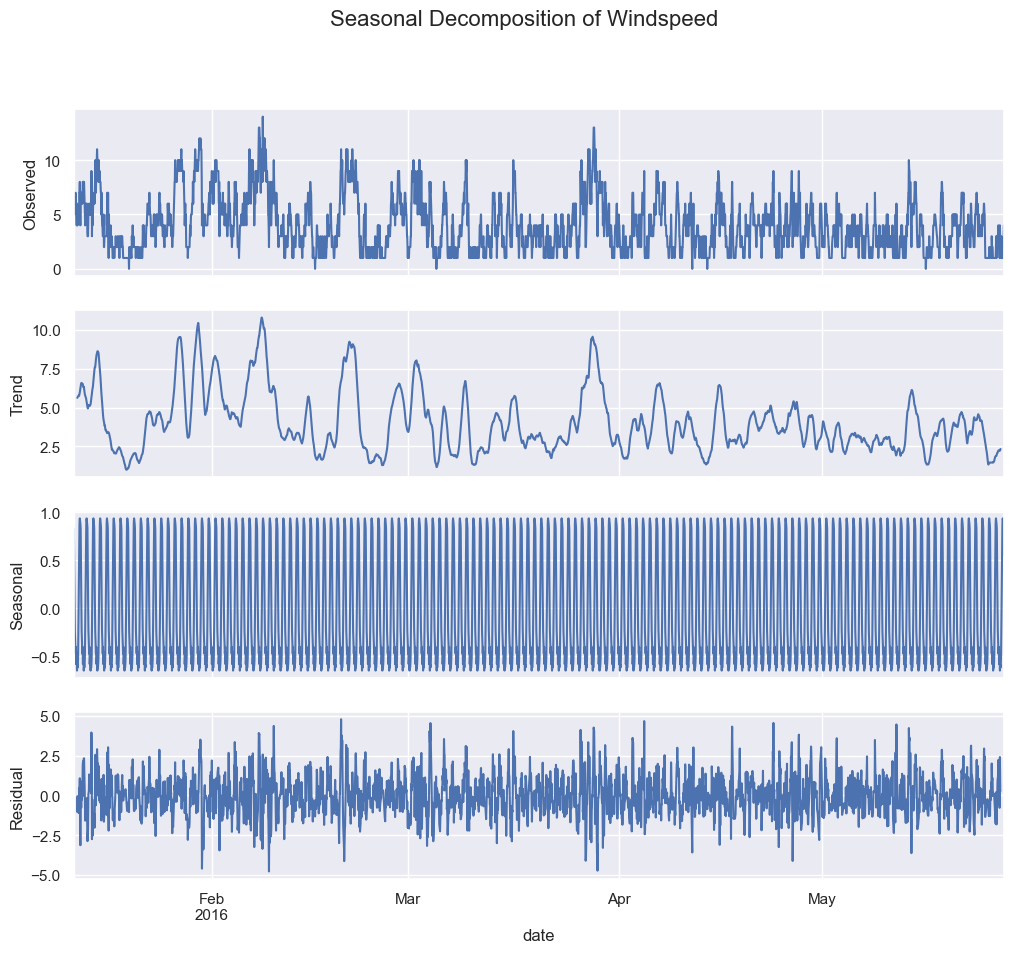

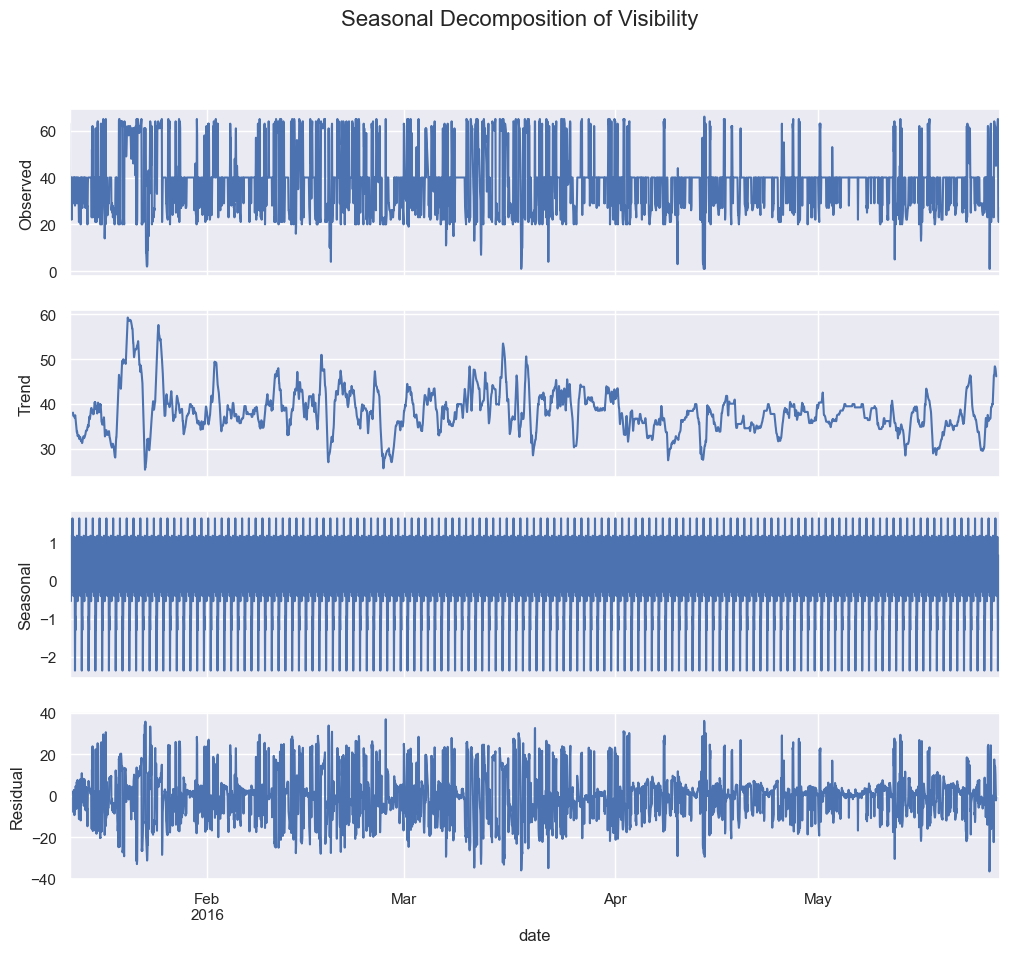

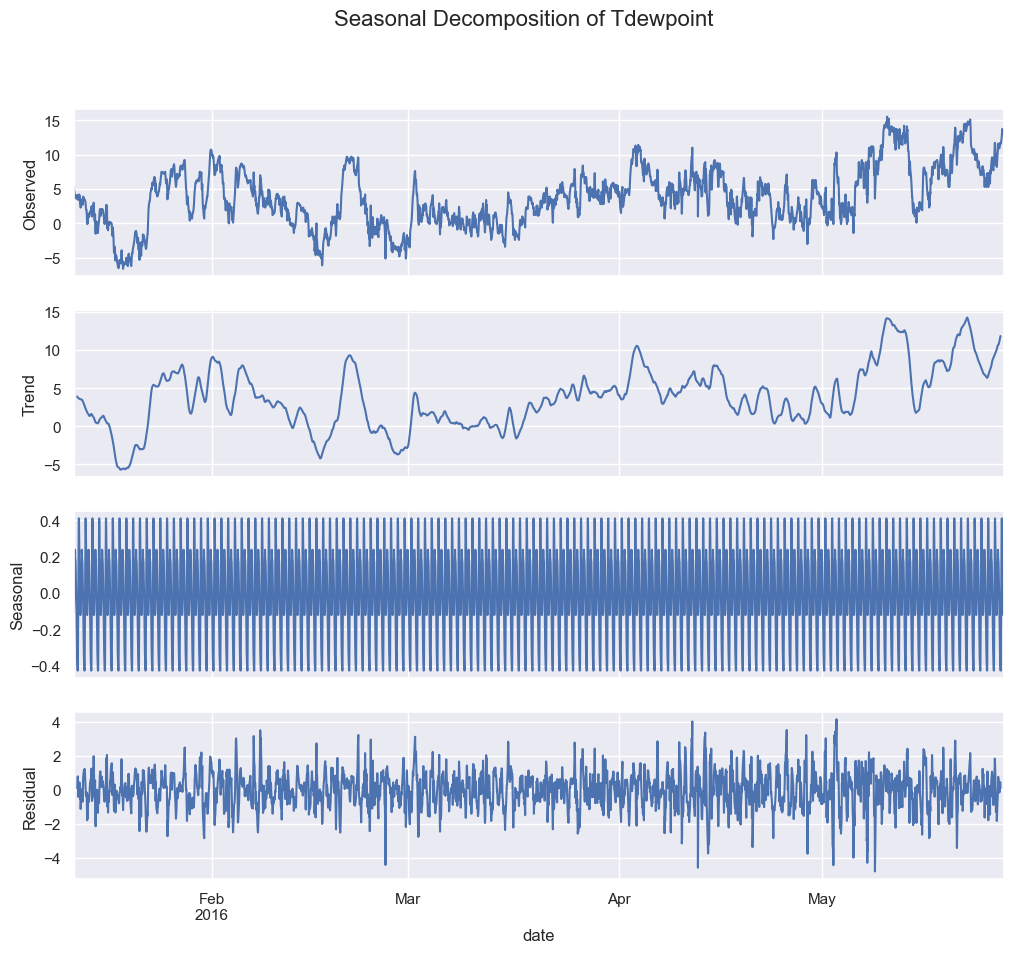

In [23]:
start_time = time.time()

# Decompose and plot each column
for column in sub_df.columns:
    decompose_and_plot(sub_df, column, model='additive', period=144) # 24hrs * 60 mins / 10 =144  (since there are 144 ten-minute intervals in a day)

end_time: float = time.time() - start_time

In [24]:
print(f"Plot decomposition took: {format_time(end_time)}")

Plot decomposition took: 0h 29m 59.11s


#### Doesn't show any trends from decomposition

In [25]:
# Create the ACF and PACF Plotting Function
def plot_acf_pacf(df, column, lags=50):
    """
    Plot ACF and PACF for a given column.
    
    Parameters:
    df (DataFrame): The DataFrame containing the time series data.
    column (str): The column name to analyze.
    lags (int): The number of lags to include in the plots.
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    fig.suptitle(f'ACF and PACF for {column}', fontsize=16)
    
    plot_acf(df[column], lags=lags, ax=axes[0])
    axes[0].set_title('Autocorrelation')
    
    plot_pacf(df[column], lags=lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation')
    
    plt.show()

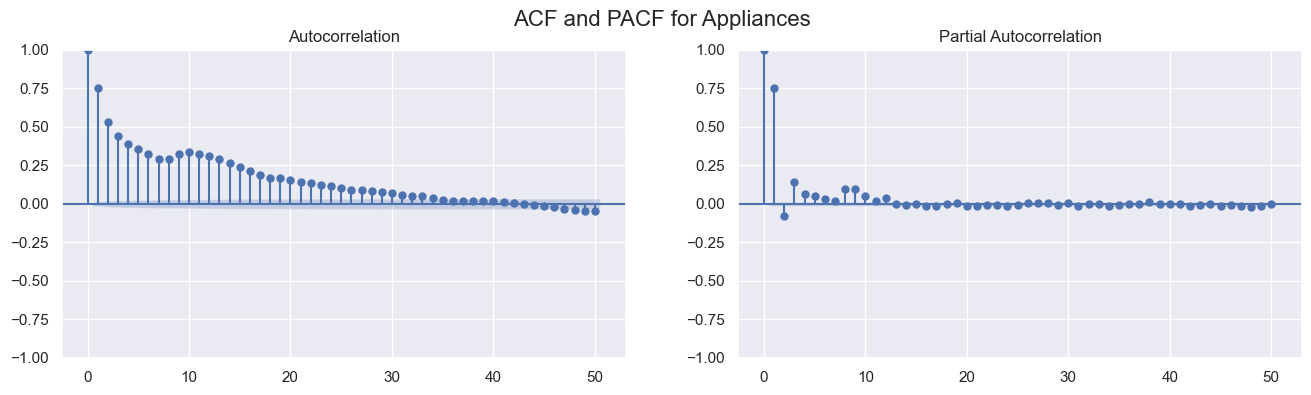

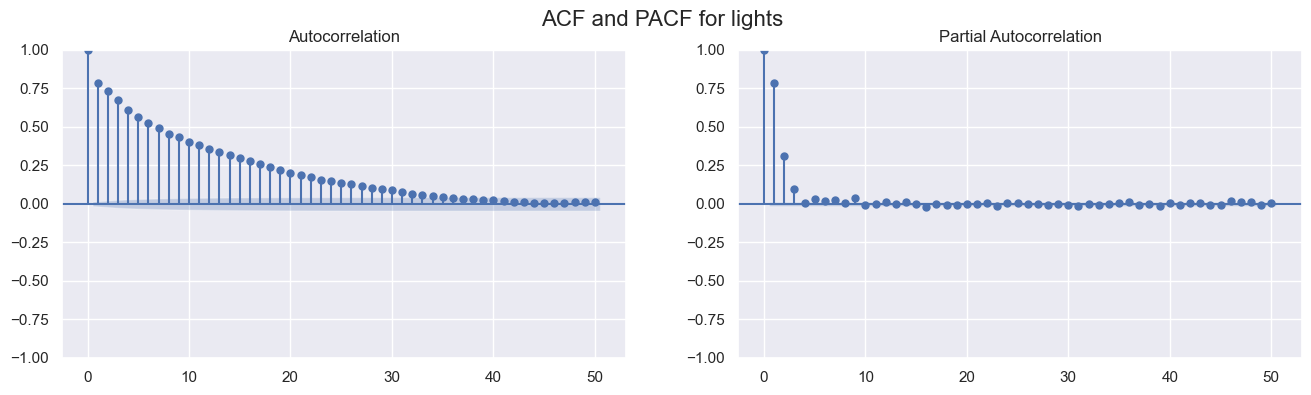

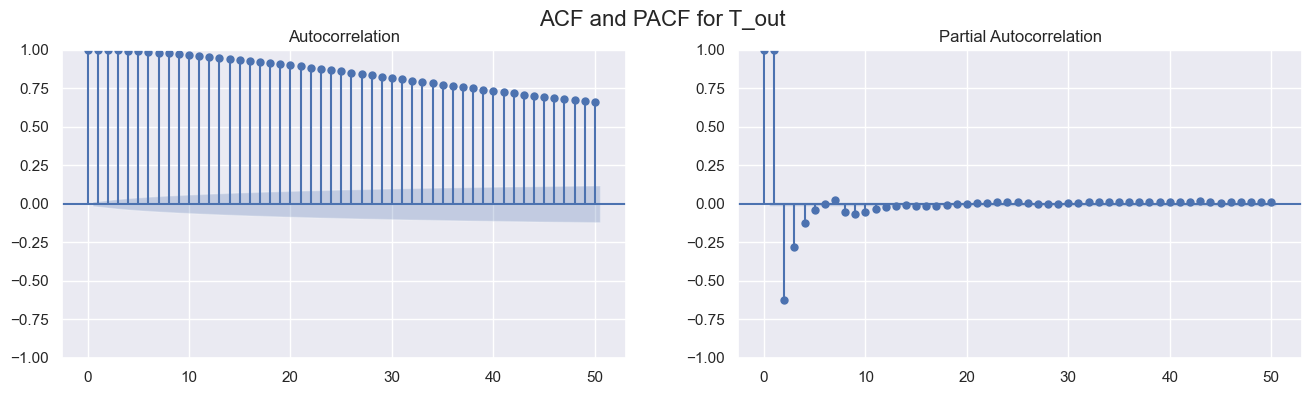

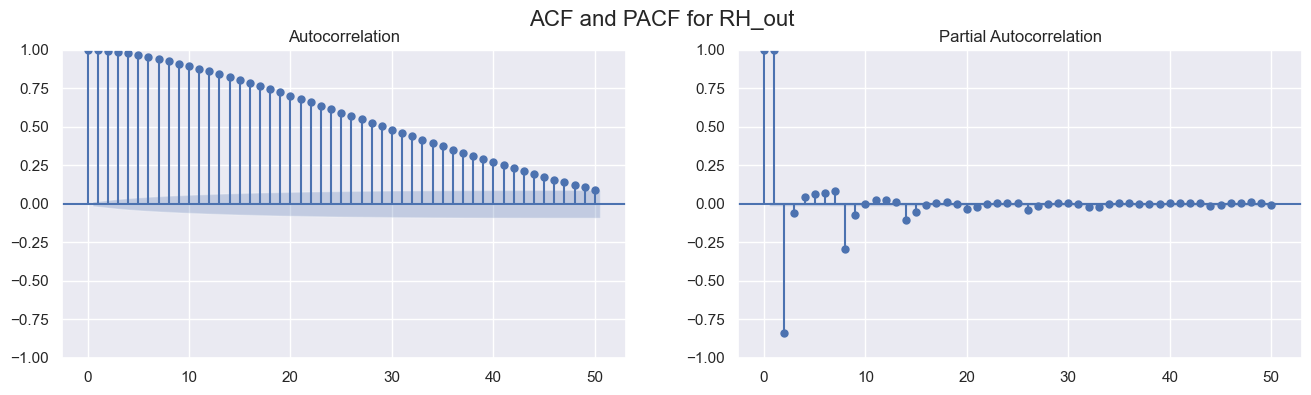

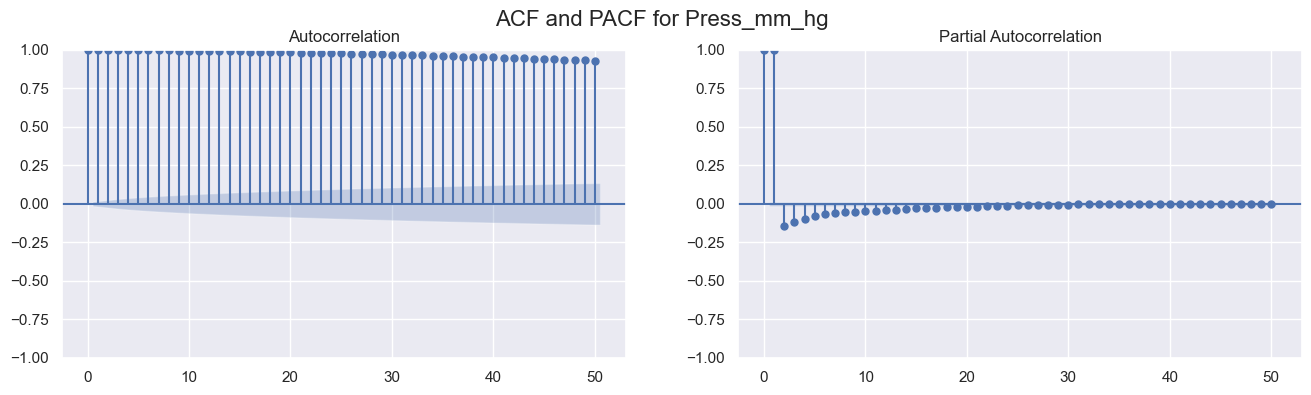

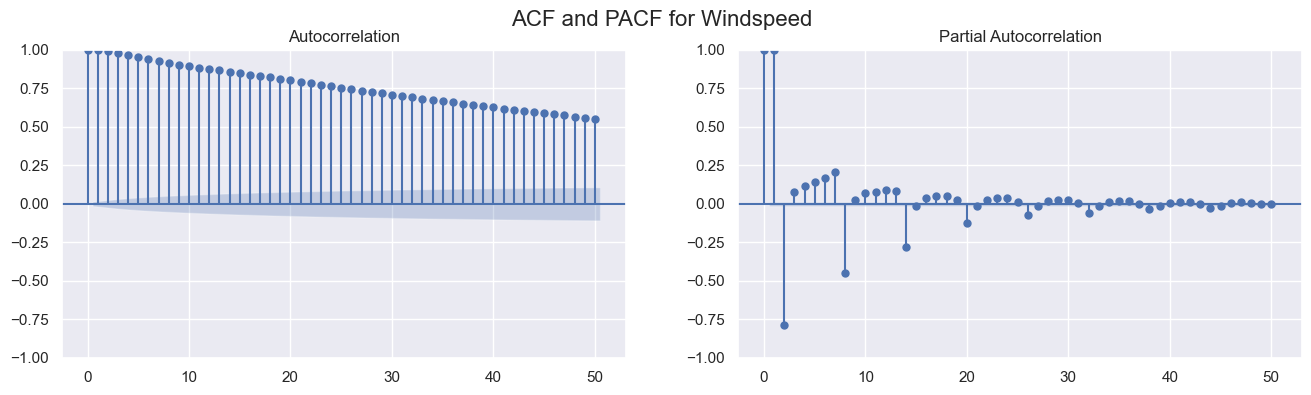

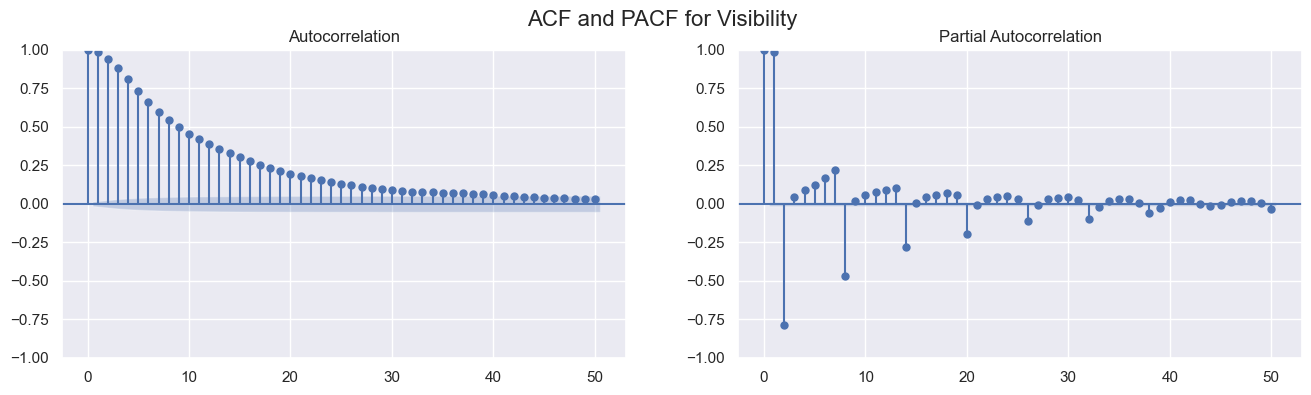

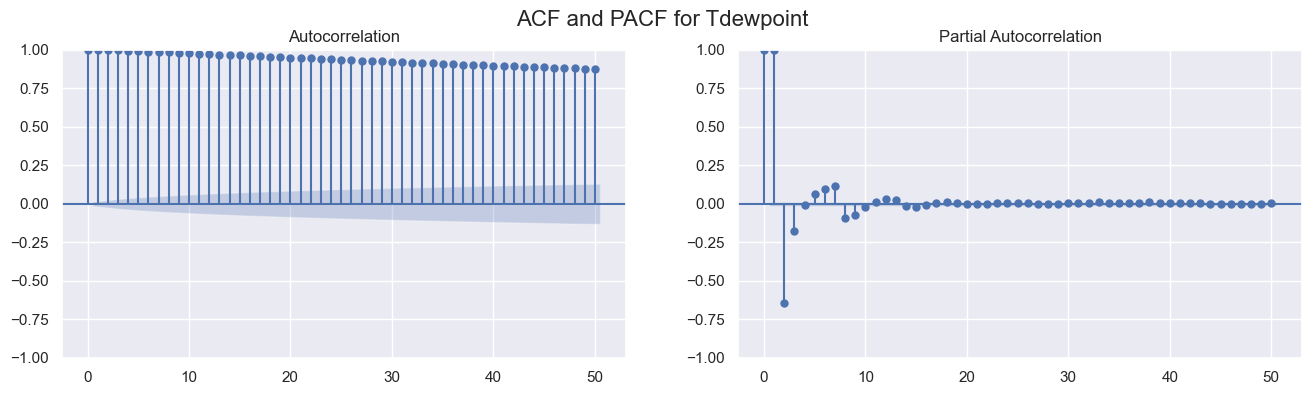

In [26]:
# Plot ACF and PACF for each column
for column in sub_df.columns:
    plot_acf_pacf(sub_df, column, lags=50)

#### The series do not exhibit trends or regular seasonal patterns. Therefore we assume that they are the realisation of a stationary VAR(p) process.

### Inspect Correlograms

#### The Hurst exponent is a statistical measure used to assess the long-term memory of time series data. It quantifies the degree of autocorrelation within a time series, indicating how future values are influenced by past values.

- Values between 0.5 and 1: Indicate a persistent, trending time series. High values tend to be followed by high values, and low values by low values.
- Values between 0 and 0.5: Indicate an anti-persistent, mean-reverting time series. High values are likely followed by low values, and vice versa.
- Value of 0.5: Suggests a random walk, where future values are not dependent on past values

#### The Q-statistic (or Q-stat) is a test statistic used in time series analysis to test for the presence of autocorrelation at different lags.
- Low P-value (typically < 0.05): Reject the null hypothesis. This suggests that there is significant autocorrelation in the residuals, indicating that the model may not be adequately capturing all the patterns in the data.
- High P-value (typically > 0.05): Fail to reject the null hypothesis. This suggests that there is no significant autocorrelation in the residuals, indicating that the model is likely a good fit for the data

In [27]:
# code from https://goldinlocks.github.io/Multivariate-time-series-models/

# Hurst Exponent
def hurst(ts):
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0]*2.0
    
# Correlogram Plot
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

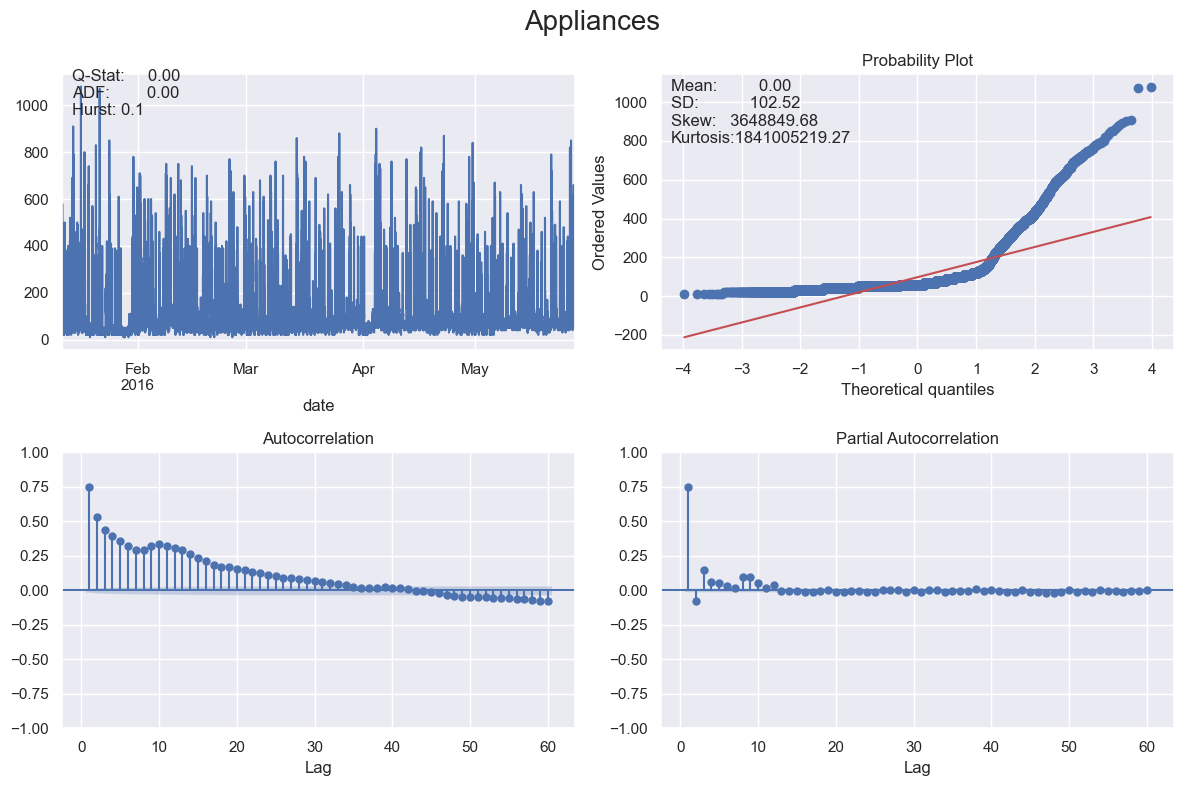

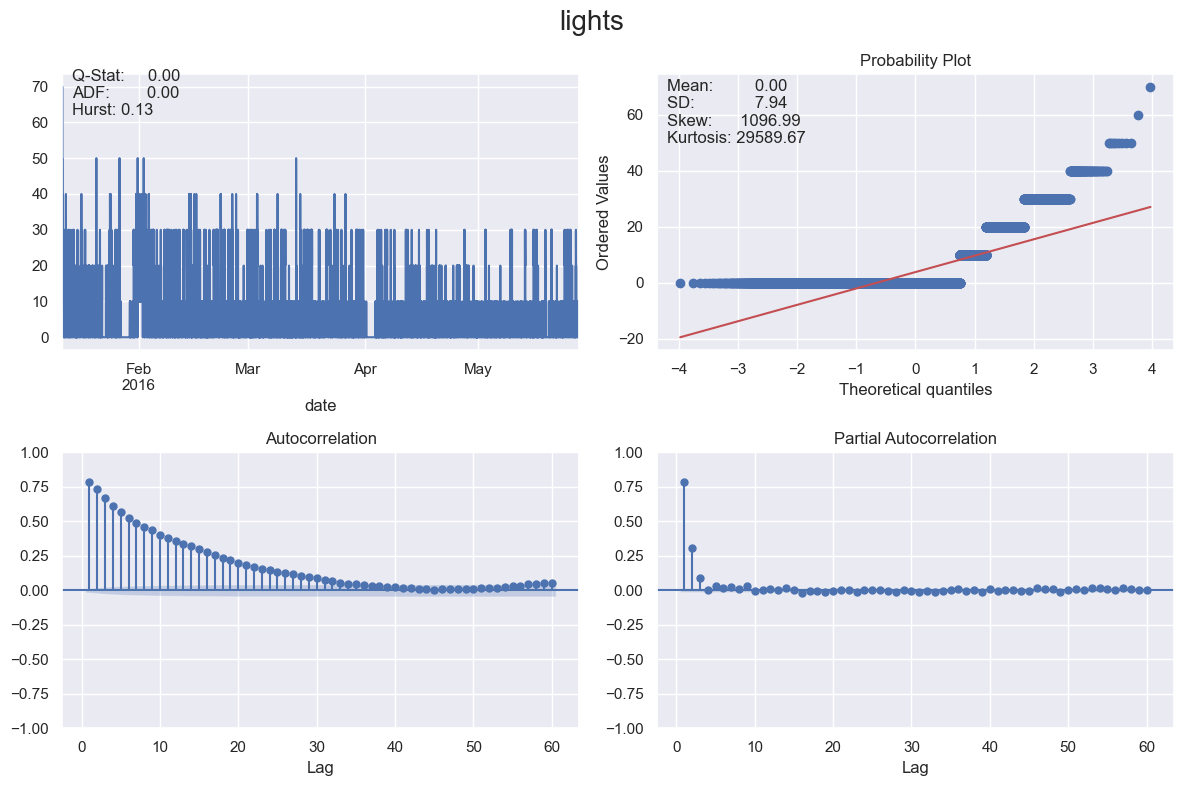

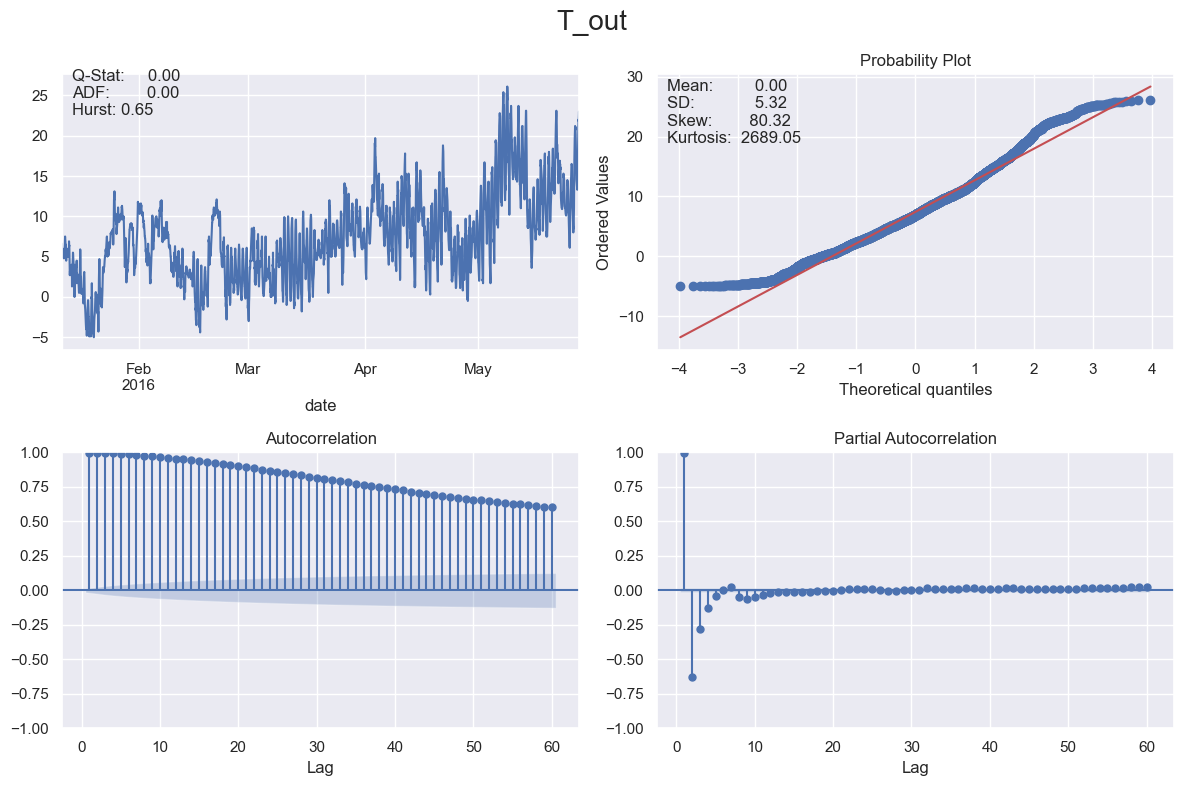

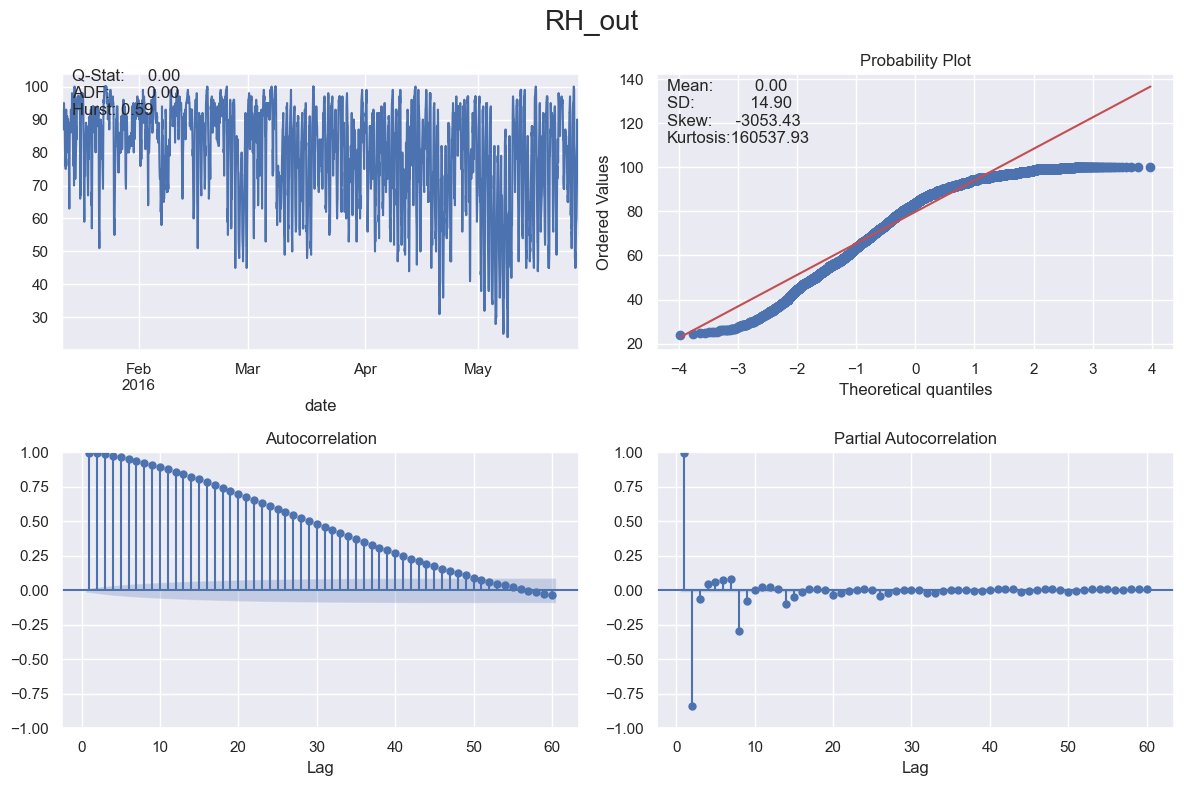

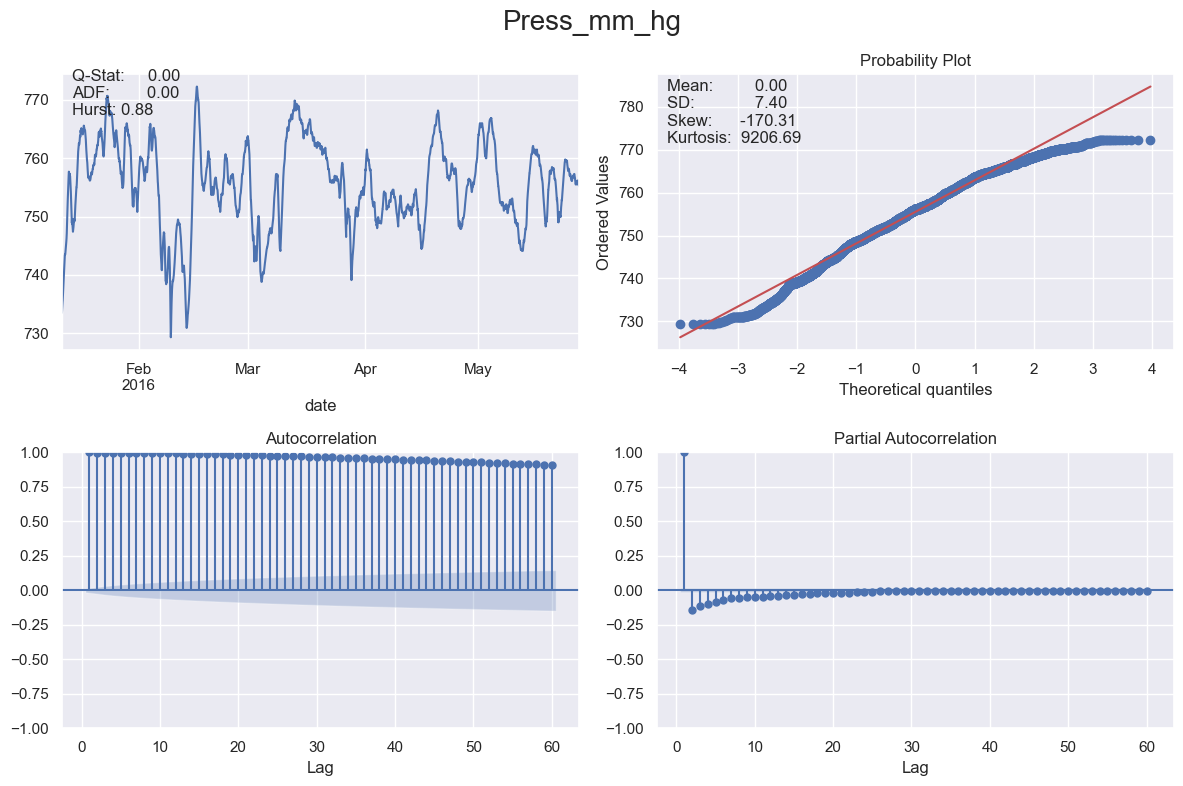

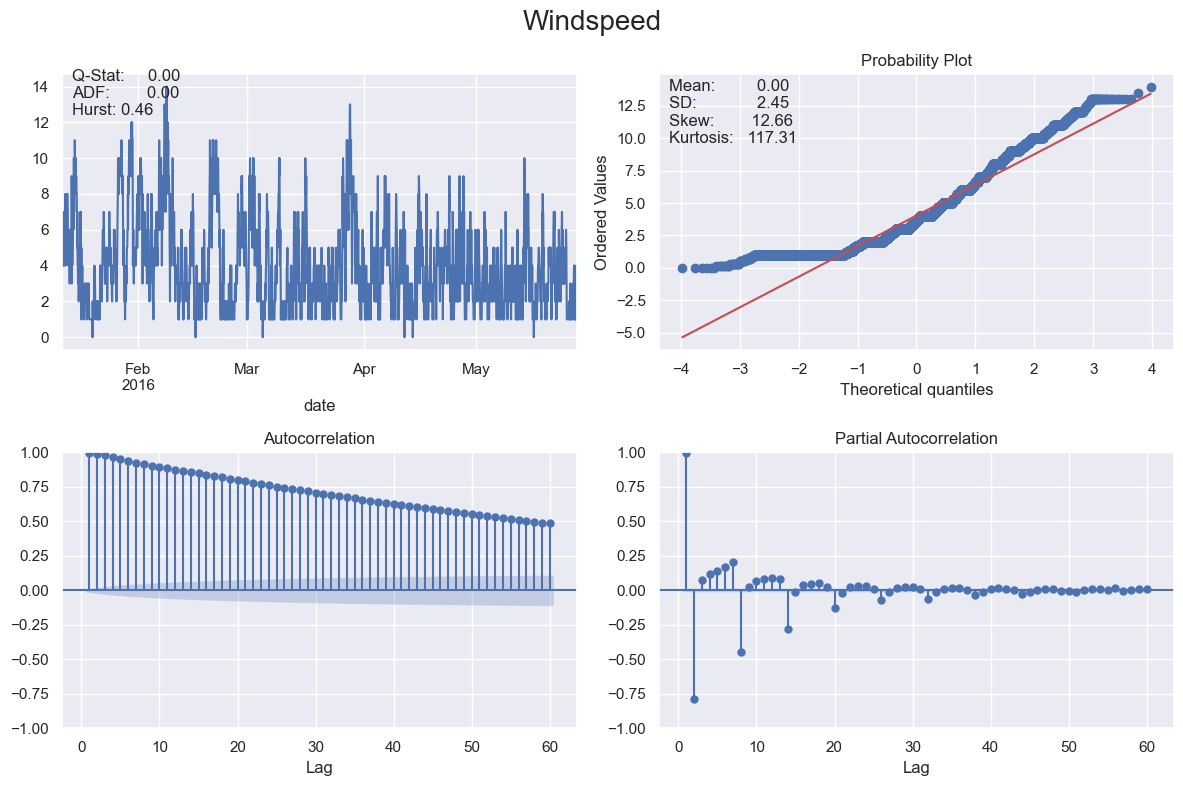

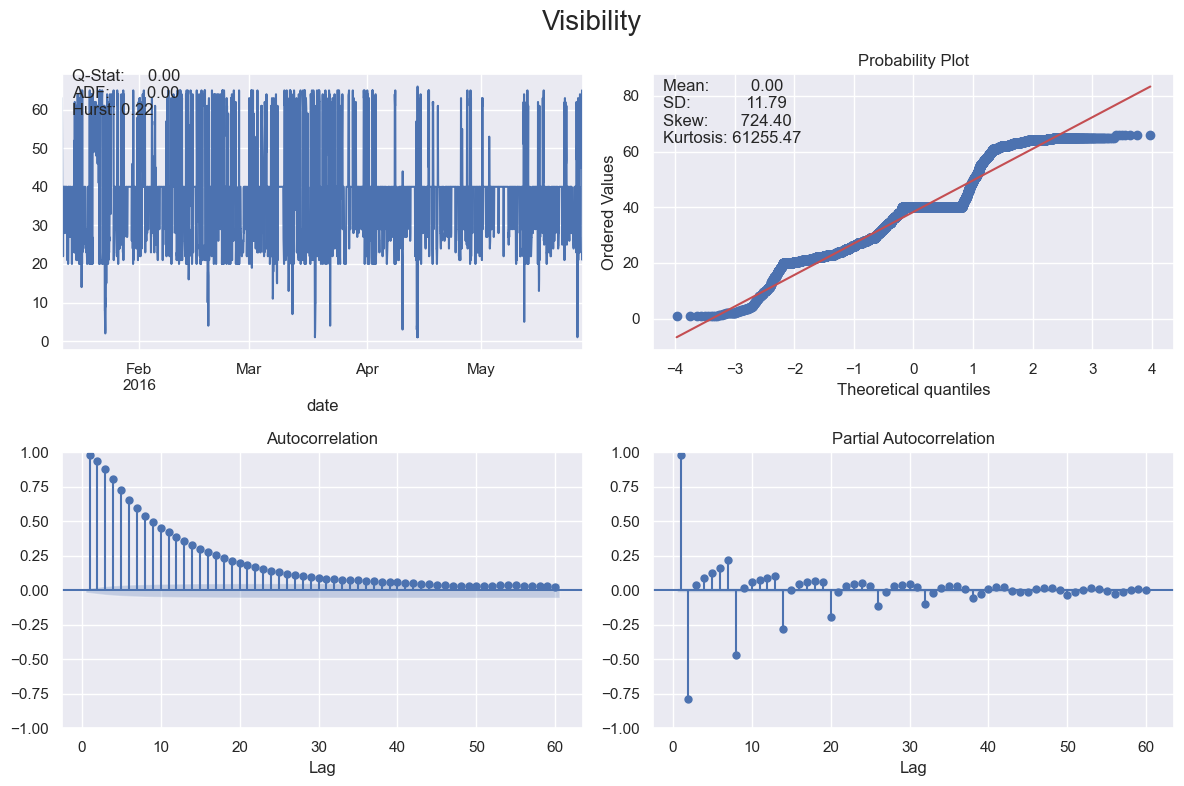

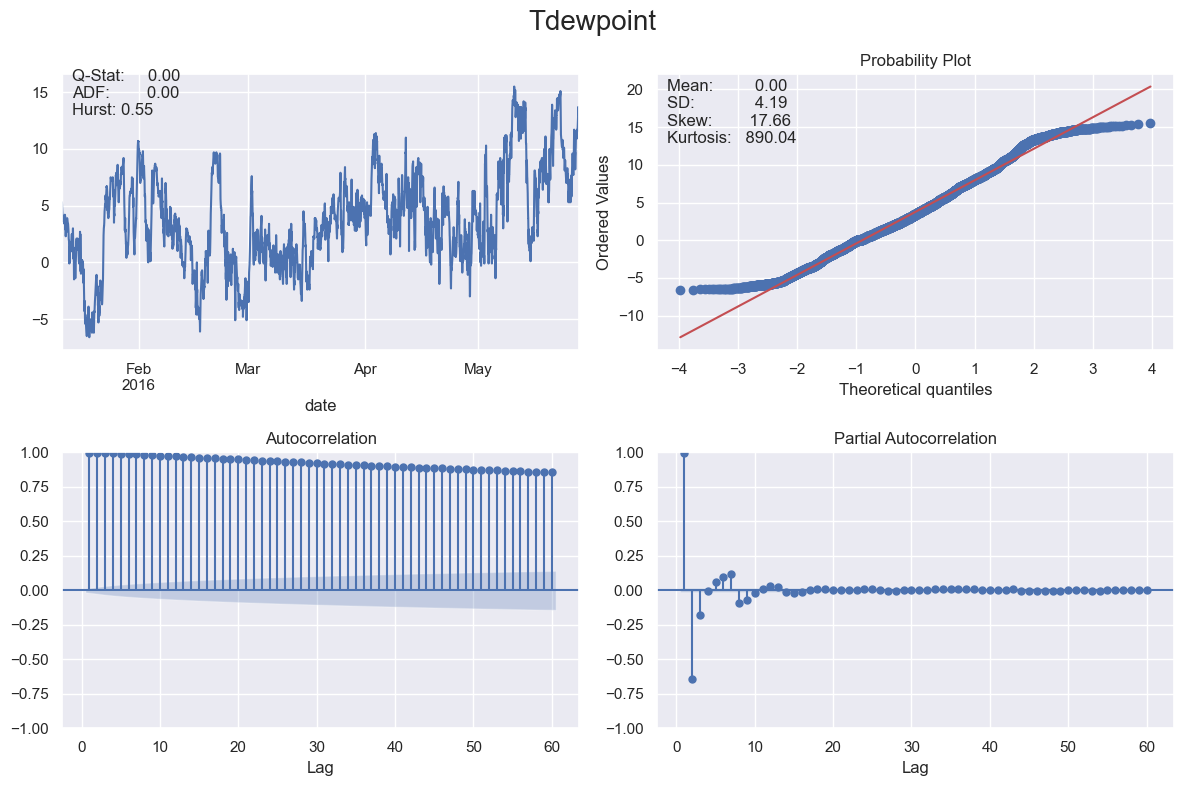

In [28]:
start_time = time.time()


for i in sub_df.columns:
    plot_correlogram(sub_df[i], lags=60, title=f'{i}')

end_time = time.time() - start_time

In [29]:
print(f"Plot correlogram took: {format_time(end_time)}")

Plot correlogram took: 0h 2m 4.91s


### Split the Series into Training and Testing Data

In [30]:
# Train-Test-Split
train_ratio = 0.8

def splitter(data_df, ratio):
    end = round(len(data_df)*ratio)
    train_df = data_df[:end]
    test_df = data_df[end:]
    return train_df, test_df

train_df, test_df = splitter(sub_df, train_ratio)

In [31]:
print(train_df.shape) 
print(test_df.shape)  

(15788, 8)
(3947, 8)


## Vector Autoregressive Methods

#### Fitting a VAR model involves the selection of a single parameter: the model order or lag length p. The most common approach in selecting the best model is choosing the p that minimizes one or more information criteria evaluated over a range of model orders. 

#### Select the Optimal Lag Order: Use information criteria like AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion), HQIC (Hannan-Quinn Information Criterion), or Akaike’s Final Prediction Error Criterion (FPE) to determine the optimal lag order.

###    We have 4 criteria available for the lag order selection:
    
  -  Akaike Information Criterion (AIC): AIC is a criterion that measures the goodness of fit of a statistical model while taking into account the model’s complexity. The goal is to minimize this value, so a lower AIC indicates a better-fitting model.
  -  Bayesian Information Criterion (BIC): BIC is similar to AIC but penalizes model complexity more heavily. It aims to strike a balance between model fit and complexity. Like AIC, the goal is to minimize the BIC value.
  -  Hannan-Quinn Information Criterion (HQIC): HQIC is another information criterion used for model selection in VAR models. It addresses the issue of small sample sizes by providing a different penalty term for model complexity. The goal is also to minimize this value.
  -  Final Prediction Error (FPE): FPE is a criterion used specifically for VAR models. It measures the mean squared error of the model’s one-step-ahead prediction. The goal is to minimize this value.

In [32]:
# https://mlpills.dev/time-series/step-by-step-guide-to-multivariate-time-series-forecasting-with-var-models/

C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


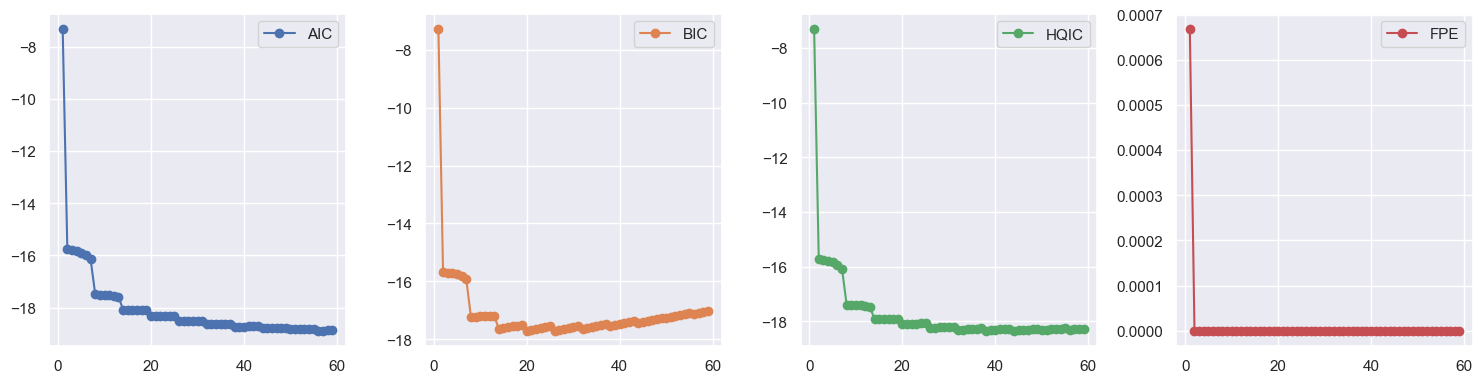

In [33]:
aic, bic, fpe, hqic = [], [], [], []
model = VAR(train_df) 
p = np.arange(1,60)
for i in p:
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)
    fpe.append(result.fpe)
    hqic.append(result.hqic)
lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                'BIC': bic, 
                                'HQIC': hqic,
                                'FPE': fpe}, 
                               index=p)    
fig, ax = plt.subplots(1, 4, figsize=(15, 4), sharex=True)

lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
plt.tight_layout()
plt.show()

In [34]:
model = VAR(endog = train_df)
res = model.select_order() 
res.summary()

C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.table.SimpleTable'>

In [35]:
print(f"The optimal lag order selected: {res.selected_orders}")

The optimal lag order selected: {'aic': 38, 'bic': 26, 'hqic': 38, 'fpe': 38}


#### We find BIC lowest at p=26, and we also observe an elbow in the plots for AIC and HQID at p=38 , so we choose the number of lags to be 26.

### Testing the forecasting relevance of endogenous variables:*

| Condition | Action| Model
| :-- | :-- | :-- |
|Stationary variables|	Apply Granger-causality testing	|Stationary VAR
|Nonstationary variables, not cointegrated|	Difference the variables and apply Granger-causality testing|	Stationary VAR of differenced variables
|Nonstationary variables, cointegrated	|Apply Granger-causality testing	|VECM (Vector Error Correction Model)
|No cointegration	|Exclude error-correction term and conduct testing	|Wald test in a stationary VAR

* from  https://medium.com/geekculture/vector-auto-regressive-var-models-for-multivariate-time-series-forecasting-106bb6f74add

#### The Granger Causality test is a statistical hypothesis test used to determine if one time series can predict another time series. In the context of Vector Autoregression (VAR) models, it helps to identify whether past values of one variable contain useful information for forecasting another variable.

In [36]:
# code from https://phdinds-aim.github.io/time_series_handbook/04_GrangerCausality/04_GrangerCausality.html
# test the variables for Granger Causality

def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [37]:
p=26
grangers_df = granger_causation_matrix(train_df, train_df.columns, p)  
grangers_df


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=15785, df_num=1
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=21166.2977, p=0.0000  , df_denom=15785, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=15783, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=2
parameter F test:         F=10692.0079, p=0.0000  , df_denom=15783, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=15781, df_num=3
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=7355.2233, p=0.0000  , df_denom=15781, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0

C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=0.0000  , p=1.0000  , df_denom=15755, df_num=16
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=16
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=16
parameter F test:         F=1850.9123, p=0.0000  , df_denom=15755, df_num=16

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=15753, df_num=17
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=17
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=17
parameter F test:         F=1741.9830, p=0.0000  , df_denom=15753, df_num=17

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=15751, df_num=18
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=18
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=18
parameter F test:         F=1646.1341, p=0.0000  , df_denom=15751, df_num=18

Granger Causality
number of lags (no zero) 19
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=15749

C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17

ssr based F test:         F=-0.7741 , p=1.0000  , df_denom=15757, df_num=15
ssr based chi2 test:   chi2=-11.6238, p=1.0000  , df=15
likelihood ratio test: chi2=-11.6281, p=1.0000  , df=15
parameter F test:         F=0.0020  , p=0.9646  , df_denom=15757, df_num=1

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=-0.0074 , p=1.0000  , df_denom=15755, df_num=16
ssr based chi2 test:   chi2=-0.1184 , p=1.0000  , df=16
likelihood ratio test: chi2=-0.1184 , p=1.0000  , df=16
parameter F test:         F=0.0075  , p=0.9311  , df_denom=15755, df_num=1

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=-53.4510, p=1.0000  , df_denom=15753, df_num=17
ssr based chi2 test:   chi2=-909.7055, p=1.0000  , df=17
likelihood ratio test: chi2=-936.9971, p=1.0000  , df=17
parameter F test:         F=0.0051  , p=0.9433  , df_denom=15753, df_num=1

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=15751, df

C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 22, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 23, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=0.0000  , p=1.0000  , df_denom=15739, df_num=24
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=24
likelihood ratio test: chi2=0.0000  , p=1.0000  , df=24
parameter F test:         F=831114.8388, p=0.0000  , df_denom=15739, df_num=24

Granger Causality
number of lags (no zero) 25
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=15737, df_num=25
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=25
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=25
parameter F test:         F=798106.6413, p=0.0000  , df_denom=15737, df_num=25

Granger Causality
number of lags (no zero) 26
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=15735, df_num=26
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=26
likelihood ratio test: chi2=0.0000  , p=1.0000  , df=26
parameter F test:         F=777870.6962, p=0.0000  , df_denom=15735, df_num=26

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=270.7699, p=0.0000  , df_denom=

C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=0.0000  , p=1.0000  , df_denom=15759, df_num=14
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=14
likelihood ratio test: chi2=0.0000  , p=1.0000  , df=14
parameter F test:         F=992881.3606, p=0.0000  , df_denom=15759, df_num=14

Granger Causality
number of lags (no zero) 15
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=15757, df_num=15
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=15
likelihood ratio test: chi2=0.0000  , p=1.0000  , df=15
parameter F test:         F=928388.3004, p=0.0000  , df_denom=15757, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=-1.7339 , p=1.0000  , df_denom=15755, df_num=16
ssr based chi2 test:   chi2=-27.7720, p=1.0000  , df=16
likelihood ratio test: chi2=-27.7964, p=1.0000  , df=16
parameter F test:         F=0.0045  , p=0.9462  , df_denom=15755, df_num=1

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=157

C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 19, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 1
  warnings.warn('covariance of constraints does not have full '


ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=15741, df_num=23
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=23
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=23
parameter F test:         F=648309.7595, p=0.0000  , df_denom=15741, df_num=23

Granger Causality
number of lags (no zero) 24
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=15739, df_num=24
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=24
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=24
parameter F test:         F=622263.2958, p=0.0000  , df_denom=15739, df_num=24

Granger Causality
number of lags (no zero) 25
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=15737, df_num=25
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=25
likelihood ratio test: chi2=0.0000  , p=1.0000  , df=25
parameter F test:         F=598434.1615, p=0.0000  , df_denom=15737, df_num=25

Granger Causality
number of lags (no zero) 26
ssr based F test:         F=0.0000  , p=1.0000  , df_denom

C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12,

ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=15757, df_num=15
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=15
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=15
parameter F test:         F=148358.5391, p=0.0000  , df_denom=15757, df_num=15

Granger Causality
number of lags (no zero) 16
ssr based F test:         F=-0.0643 , p=1.0000  , df_denom=15755, df_num=16
ssr based chi2 test:   chi2=-1.0296 , p=1.0000  , df=16
likelihood ratio test: chi2=-1.0296 , p=1.0000  , df=16
parameter F test:         F=0.0221  , p=0.8818  , df_denom=15755, df_num=1

Granger Causality
number of lags (no zero) 17
ssr based F test:         F=-0.0541 , p=1.0000  , df_denom=15753, df_num=17
ssr based chi2 test:   chi2=-0.9207 , p=1.0000  , df=17
likelihood ratio test: chi2=-0.9207 , p=1.0000  , df=17
parameter F test:         F=0.0081  , p=0.9281  , df_denom=15753, df_num=1

Granger Causality
number of lags (no zero) 18
ssr based F test:         F=-0.6658 , p=1.0000  , df_denom=15751, 

C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 16, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 18, but rank is 1
  warnings.warn('covariance of constraints does not have full '
C:\Users\simon\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 19

ssr based F test:         F=-1.9584 , p=1.0000  , df_denom=15747, df_num=20
ssr based chi2 test:   chi2=-39.2194, p=1.0000  , df=20
likelihood ratio test: chi2=-39.2682, p=1.0000  , df=20
parameter F test:         F=0.0058  , p=0.9391  , df_denom=15747, df_num=1

Granger Causality
number of lags (no zero) 21
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=15745, df_num=21
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=21
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=21
parameter F test:         F=116459.7392, p=0.0000  , df_denom=15745, df_num=21

Granger Causality
number of lags (no zero) 22
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=15743, df_num=22
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=22
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=22
parameter F test:         F=111325.9767, p=0.0000  , df_denom=15743, df_num=22

Granger Causality
number of lags (no zero) 23
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=157

Appliances_x  lights_x  T_out_x  RH_out_x  Press_mm_hg_x  \
Appliances_y         1.0000    0.0000   0.0000    0.0000         0.0001   
lights_y             0.0000    1.0000   0.0969    0.0676         0.0000   
T_out_y              0.0019    0.0000   1.0000    0.0000         0.0000   
RH_out_y             0.0000    0.0000   0.0000    1.0000         0.0000   
Press_mm_hg_y        0.0000    0.0000   0.0000    0.0000         1.0000   
Windspeed_y          0.0000    0.0127   0.0000    0.0000         0.0000   
Visibility_y         0.4379    0.0195   0.0000    0.0034         0.3171   
Tdewpoint_y          0.0910    0.5635   0.0000    0.0000         0.0004   

               Windspeed_x  Visibility_x  Tdewpoint_x  
Appliances_y        0.0000        0.1082       0.0017  
lights_y            0.0041        0.4303       0.0082  
T_out_y             0.0000        0.2534       0.0000  
RH_out_y            0.0028        0.0029       0.0000  
Press_mm_hg_y       0.0000        0.0590       0.0000  
Windspeed_y         1.0000        0.0005       0.0000  
Visibility_y        0.3067        1.0000       0.5059  
Tdewpoint_y         0.0000        0.0068       1.0000

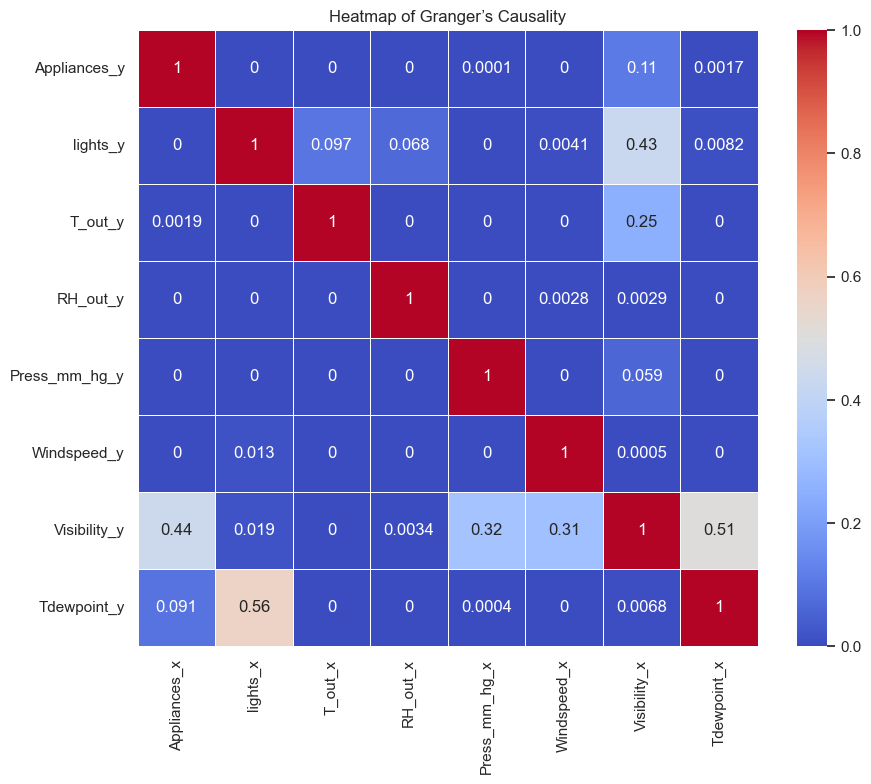

In [38]:
# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(grangers_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Granger’s Causality')
plt.show()

#### If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row).

#### Results:

#### Appliances Granger causes changes in the lights, T_out, RH_out, Pressure, Windspeed. This means that Appliances_x data improves changes in lights, T_out, RH_out, Pressure, Windspeed prediction performance.

#### On the other hand, changes in Visibility does not Granger cause Appliances, lights, T_out, Pressure. This means that changes in Visibility data does not improve Appliances, lights, T_out, Pressure prediction performance.

#### Then trained and fitted the train set into VAR and fitted it with 26 lags. And printed out a summary of the trained and fitted data, being a summary of regression results:

In [39]:
#  Applying VAR model and Fit the VAR model
VAR_model = VAR(train_df, freq="10min")
VAR_results = VAR_model.fit(maxlags=p, ic='bic')
# Print the summary of the model
print(VAR_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 01, Sep, 2024
Time:                     12:22:44
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -17.7011
Nobs:                     15762.0    HQIC:                  -18.2451
Log likelihood:          -31339.6    FPE:                9.10676e-09
AIC:                     -18.5143    Det(Omega_mle):     8.19592e-09
--------------------------------------------------------------------
Results for equation Appliances
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  59.381663        71.278952            0.833           0.405
L1.Appliances           0.784033         0.008038           97.536           0.000
L1.lights               0.468850         0.1101

In [40]:
VAR_results.resid

Appliances    lights     T_out    RH_out  Press_mm_hg  \
date                                                                         
2016-01-11 21:20:00    4.334904  7.705937  0.004447 -0.070870     0.002297   
2016-01-11 21:30:00   -0.031428 -3.583250  0.005570 -0.031227     0.003414   
2016-01-11 21:40:00   18.676137  0.490123  0.016772 -0.125568     0.001243   
2016-01-11 21:50:00    4.325296  1.876301  0.007907 -0.009932     0.005878   
2016-01-11 22:00:00   13.199434  2.476926  0.006603 -0.039332     0.000997   
...                         ...       ...       ...       ...          ...   
2016-04-30 07:30:00   14.352636 -0.583161 -0.005557  0.021676     0.001758   
2016-04-30 07:40:00   -1.354852 -0.689975 -0.005419  0.018656     0.001578   
2016-04-30 07:50:00  -23.923672 -0.743182 -0.005862  0.025130     0.001627   
2016-04-30 08:00:00   16.607206 -0.638411 -0.005560  0.020481     0.001833   
2016-04-30 08:10:00  220.069349 -0.356974  0.076112 -0.728407     0.004462   

                     Windspeed  Visibility  Tdewpoint  
date                                                   
2016-01-11 21:20:00  -0.006057    0.076212  -0.008403  
2016-01-11 21:30:00   0.002585    0.006557  -0.001267  
2016-01-11 21:40:00   0.005184    0.069239  -0.007484  
2016-01-11 21:50:00  -0.002361   -0.076254   0.006894  
2016-01-11 22:00:00  -0.005635   -0.203482  -0.000788  
...                        ...         ...        ...  
2016-04-30 07:30:00  -0.015872    0.117642  -0.002422  
2016-04-30 07:40:00  -0.013793    0.137945  -0.002888  
2016-04-30 07:50:00  -0.016285    0.138578  -0.002141  
2016-04-30 08:00:00  -0.015244    0.158069  -0.002668  
2016-04-30 08:10:00   0.021861   -0.680625  -0.008858  

[15762 rows x 8 columns]

#### Note: correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).

#### What does this mean to us?*

    If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

##### *from https://github.com/xxl4tomxu98/vector-autoregressive-model-wage-inflations/blob/main/VAR-model.ipynb

### Autocorrelation of Residuals - serial correlation of errors
#### Autocorrelation in residuals violates the assumption of independence in regression models, leading to biased and inconsistent estimates.

### Box-Pierce Test
- Purpose: The Box-Pierce test is used to check for the presence of autocorrelation at multiple lags in a time series.
- Method: It is based on the sum of squared autocorrelations up to a certain lag. The test statistic follows a chi-squared distribution.
- Application: It can be applied to any lag value, making it versatile for detecting autocorrelation over various time periods

### Durbin-Watson Statistic
- Purpose: The Durbin-Watson statistic specifically tests for first-order autocorrelation (i.e., correlation between consecutive residuals in a regression model).
- Method: It calculates the ratio of the sum of squared differences between consecutive residuals to the sum of squared residuals. The test statistic ranges from 0 to 4, where a value around 2 indicates no autocorrelation, values less than 2 indicate positive autocorrelation, and values greater than 2 indicate negative autocorrelation2.
- Application: It is limited to detecting autocorrelation at lag 1, making it less versatile than the Box-Pierce test for higher-order autocorrelations

    Durbin Watson’s Statistic
    
    To check for autocorrelation in a regression model's output
    
    Values range from 0 to 4, with a value of 2 indicating zero autocorrelation (no significant serial correlation).
    Values below 2 indicate positive autocorrelation.
    Values above 2 indicate negative autocorrelation.

In [41]:
# code from https://www.kaggle.com/code/ruchi798/a-tale-of-two-cities-analyzing-trends
from statsmodels.stats.stattools import durbin_watson
def DW(model, data):
    result = durbin_watson(model.resid)

    print("{:>18} {: >15}".format(*['Columns', 'DW Statistic']))
    for col, val in zip(data.columns, result):
        print("{:>18} {: >15}".format(*[col, round(val, 2)]))

DW(VAR_results, train_df)

           Columns    DW Statistic
        Appliances             2.0
            lights             2.0
             T_out             2.0
            RH_out            1.99
       Press_mm_hg             2.0
         Windspeed            1.99
        Visibility            1.99
         Tdewpoint            1.99


In [42]:
# Perform the Ljung-Box test/ Box-Pierce test on each series of residuals
# The Ljung-Box test is a refinement of the Box-Pierce test, often providing more accurate results for smaller sample sizes.
from statsmodels.stats.diagnostic import acorr_ljungbox

for col in VAR_results.resid.columns:
    result = acorr_ljungbox(VAR_results.resid[col], lags=[26], return_df=True, boxpierce=True)
    print(f"Ljung-Box and Box-Pierce test for {col}")
    print(result)

Ljung-Box and Box-Pierce test for Appliances
     lb_stat  lb_pvalue  bp_stat  bp_pvalue
26  1.278279        1.0  1.27641        1.0
Ljung-Box and Box-Pierce test for lights
     lb_stat  lb_pvalue   bp_stat  bp_pvalue
26  0.891032        1.0  0.889713        1.0
Ljung-Box and Box-Pierce test for T_out
      lb_stat  lb_pvalue    bp_stat  bp_pvalue
26  42.706501   0.020734  42.644279   0.021047
Ljung-Box and Box-Pierce test for RH_out
       lb_stat     lb_pvalue     bp_stat     bp_pvalue
26  308.917722  3.464626e-50  308.502813  4.195627e-50
Ljung-Box and Box-Pierce test for Press_mm_hg
      lb_stat  lb_pvalue    bp_stat  bp_pvalue
26  34.043837   0.133924  33.989607   0.135286
Ljung-Box and Box-Pierce test for Windspeed
       lb_stat      lb_pvalue     bp_stat      bp_pvalue
26  674.901281  1.321026e-125  673.985402  2.054643e-125
Ljung-Box and Box-Pierce test for Visibility
      lb_stat      lb_pvalue     bp_stat      bp_pvalue
26  981.33933  3.347621e-190  980.046458  6.289610e-

##### lb_stat
- Definition: This stands for the Ljung-Box test statistic.
- Purpose: It is used to test for the presence of autocorrelation at multiple lags in a time series.
- Interpretation: A higher value indicates a stronger presence of autocorrelation.
##### lb_pvalue
- Definition: This is the p-value associated with the Ljung-Box test statistic.
- Purpose: It helps determine the statistical significance of the test statistic.
- Interpretation: A low p-value (typically less than 0.05) suggests that there is significant autocorrelation in the time series.
##### bp_stat
- Definition: This stands for the Box-Pierce test statistic.
- Purpose: Similar to the Ljung-Box test, it is used to test for autocorrelation at multiple lags.
- Interpretation: A higher value indicates a stronger presence of autocorrelation.
##### bp_pvalue
- Definition: This is the p-value associated with the Box-Pierce test statistic.
- Purpose: It helps determine the statistical significance of the Box-Pierce test statistic.
- Interpretation: A low p-value (typically less than 0.05) suggests that there is significant autocorrelation in the time series.

#### from p-value of Box-Pierce test statistic, all, except Appliances, lights , and Press_mm_hg, are significant autocorrelation at 26 lags in the time series

#### If the residuals are autocorrelated, it suggests that the model has not fully captured the underlying patterns in the data, and there may be room for improvement. 

### The Cointegration Test in the context of Vector Autoregression (VAR) models is used to determine whether a group of non-stationary time series variables are cointegrated, meaning they have a long-run equilibrium relationship despite being individually non-stationary.

    Null hypothesis: the time series are not cointegrated
    
    If the trace statistic is greater than the critical value, we reject the null hypothesis and accept the alternate hypothesis, suggesting that the series are cointegrated.

In [43]:
# code from https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(train_df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Appliances ::  2498.34   > 143.6691  =>   True
lights ::  1436.4    > 111.7797  =>   True
T_out  ::  840.46    > 83.9383   =>   True
RH_out ::  445.76    > 60.0627   =>   True
Press_mm_hg ::  249.3     > 40.1749   =>   True
Windspeed ::  102.09    > 24.2761   =>   True
Visibility ::  26.1      > 12.3212   =>   True
Tdewpoint ::  0.16      > 4.1296    =>   False


In [44]:
# code from https://www.kaggle.com/code/ruchi798/a-tale-of-two-cities-analyzing-trends
def johansens_test(df, alpha=0.05): 
    
    result = coint_johansen(df,-1,1)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = result.lr1
    cvts = result.cvt[:, d[str(1-alpha)]]
    
    print("{: >20} {: >20} {: >20} {: >10}".format(*['Column name', 'Trace Statistic' , 'Critical Value(95%)', 'Null Hypothesis Rejected' ]))
    for col, trace, cvt in zip(df.columns, traces, cvts):
        ans = "Yes" if trace > cvt else "No"
        print("{: >20} {: >20} {: >20} {: >10}".format(*[col, round(trace,2) ,cvt, ans]))

johansens_test(train_df)

         Column name      Trace Statistic  Critical Value(95%) Null Hypothesis Rejected
          Appliances              5334.26             143.6691        Yes
              lights              2947.17             111.7797        Yes
               T_out              1818.49              83.9383        Yes
              RH_out               905.51              60.0627        Yes
         Press_mm_hg                506.2              40.1749        Yes
           Windspeed               243.25              24.2761        Yes
          Visibility                 43.9              12.3212        Yes
           Tdewpoint                 0.13               4.1296         No


##### Trace Statistic (cvt): Tests the null hypothesis of ( r ) cointegrating relations against the alternative of ( n ) cointegrating relations.

#### Results: Except Tdewpoint, all variables are presence of cointegration.

### Implications: The presence of cointegration in a VAR model with stationary variables suggests that while the individual variables do not exhibit trends over time, there is still a stable, long-term relationship among them. This can be modeled using a Vector Error Correction Model (VECM), which incorporates both short-term dynamics and long-term equilibrium relationships.

### Make Predictions

In [45]:
# Forecasting
n_next_values=test_df.shape[0]

lag_order = VAR_results.k_ar  # 26
forecast_input = train_df.values[-lag_order:]
forecast = VAR_results.forecast(y=forecast_input, steps=n_next_values)

# Convert to dataframe
df_forecast = pd.DataFrame(forecast, 
                           columns=train_df.columns, 
                           index=test_df.iloc[:n_next_values].index)
df_forecast

Appliances    lights     T_out     RH_out  Press_mm_hg  \
date                                                                          
2016-04-30 08:20:00  248.892282  1.330145  5.669923  92.648120   758.230626   
2016-04-30 08:30:00  173.550874  2.066410  5.808835  91.446020   758.292953   
2016-04-30 08:40:00  143.199770  1.478899  5.948442  90.232307   758.353275   
2016-04-30 08:50:00  131.775088  2.675464  6.086478  89.023742   758.411070   
2016-04-30 09:00:00  133.042527  2.868450  6.224053  87.821386   758.466502   
...                         ...       ...       ...        ...          ...   
2016-05-27 17:20:00   97.963583  4.234280  5.952923  81.740031   755.911364   
2016-05-27 17:30:00   97.963583  4.234280  5.952923  81.740031   755.911364   
2016-05-27 17:40:00   97.963583  4.234280  5.952923  81.740031   755.911364   
2016-05-27 17:50:00   97.963583  4.234280  5.952923  81.740031   755.911364   
2016-05-27 18:00:00   97.963583  4.234280  5.952923  81.740031   755.911364   

                     Windspeed  Visibility  Tdewpoint  
date                                                   
2016-04-30 08:20:00   1.013176   39.891095   4.529803  
2016-04-30 08:30:00   1.039650   39.703709   4.489200  
2016-04-30 08:40:00   1.075798   39.427380   4.444349  
2016-04-30 08:50:00   1.123526   39.086267   4.396273  
2016-04-30 09:00:00   1.179690   38.669791   4.346673  
...                        ...         ...        ...  
2016-05-27 17:20:00   4.259633   38.701824   2.808082  
2016-05-27 17:30:00   4.259633   38.701824   2.808082  
2016-05-27 17:40:00   4.259633   38.701824   2.808082  
2016-05-27 17:50:00   4.259633   38.701824   2.808082  
2016-05-27 18:00:00   4.259633   38.701824   2.808082  

[3947 rows x 8 columns]

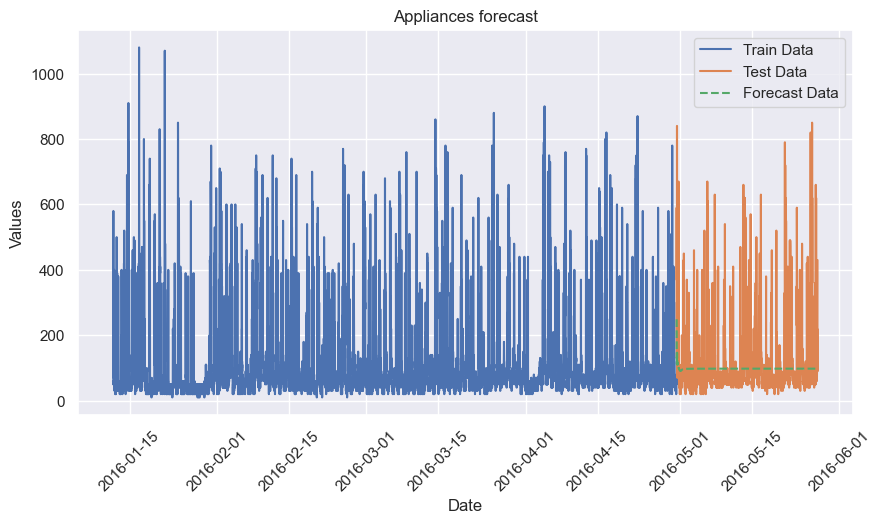

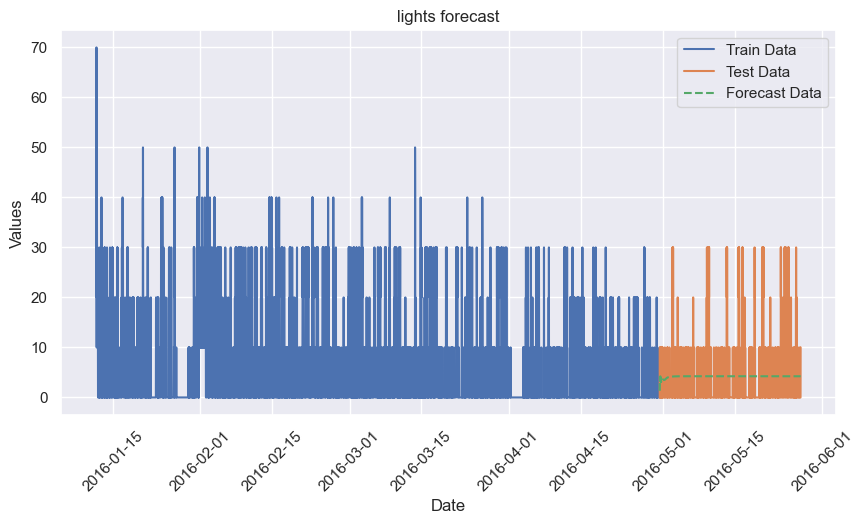

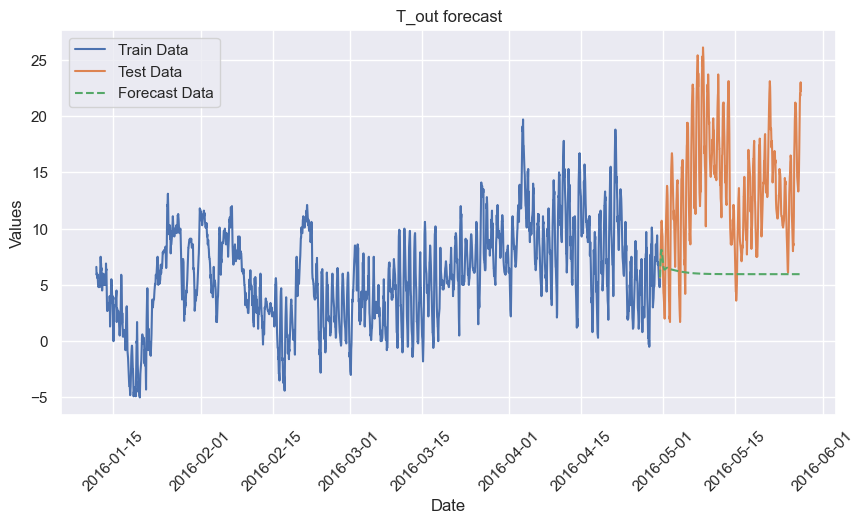

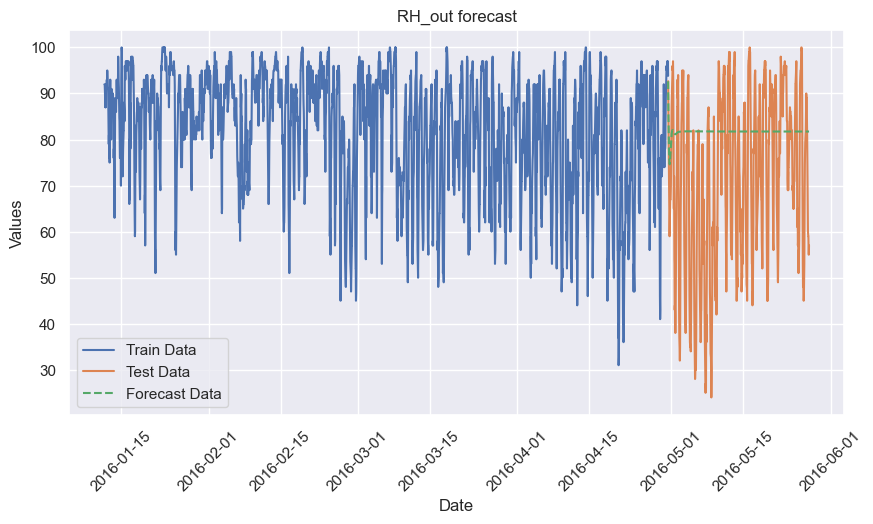

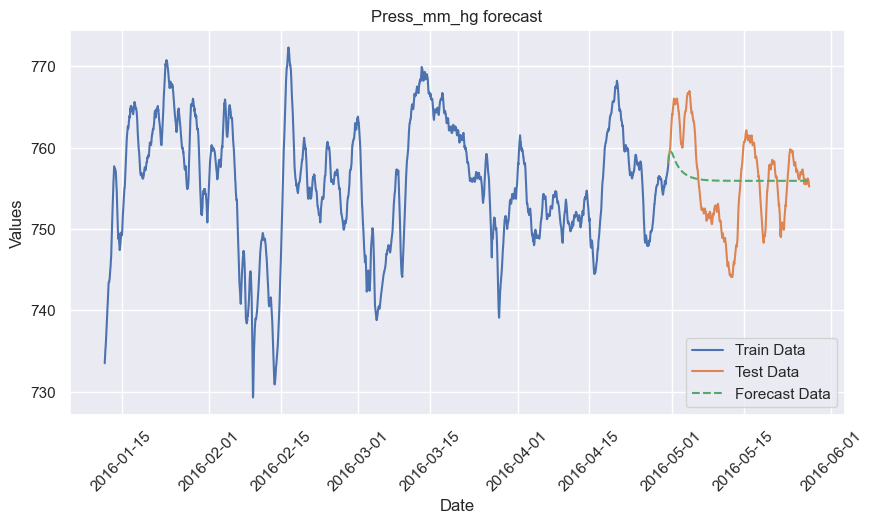

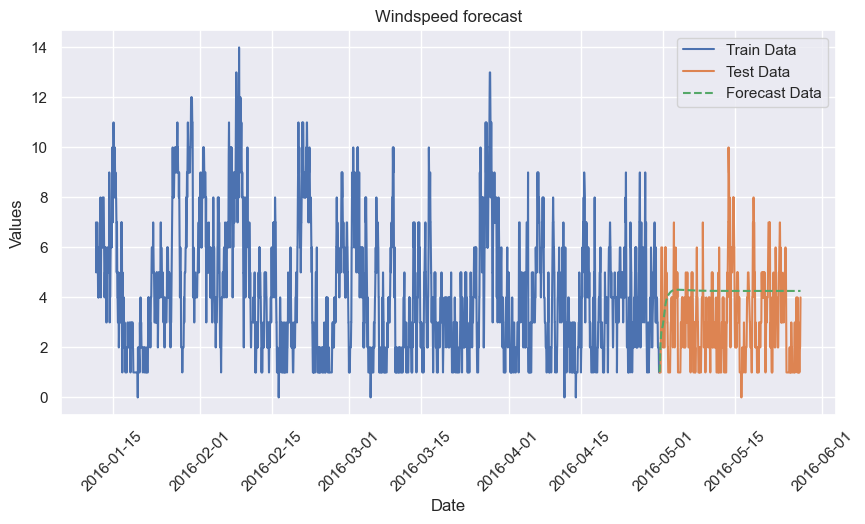

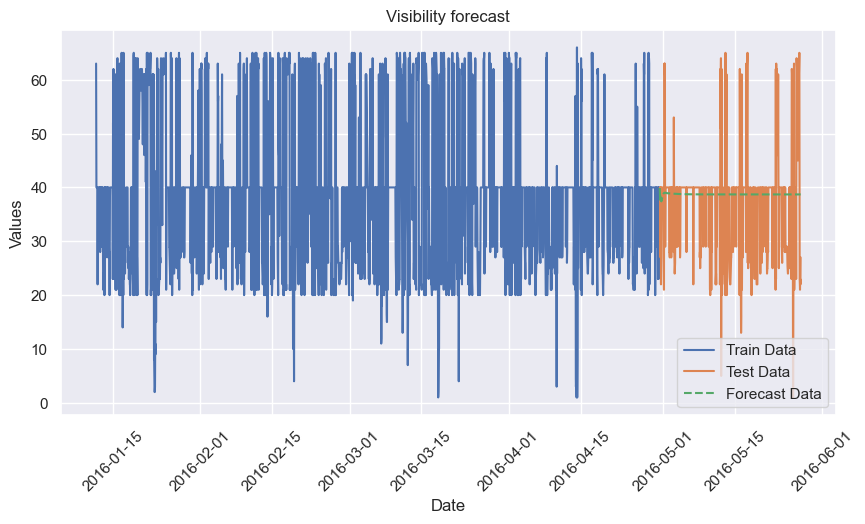

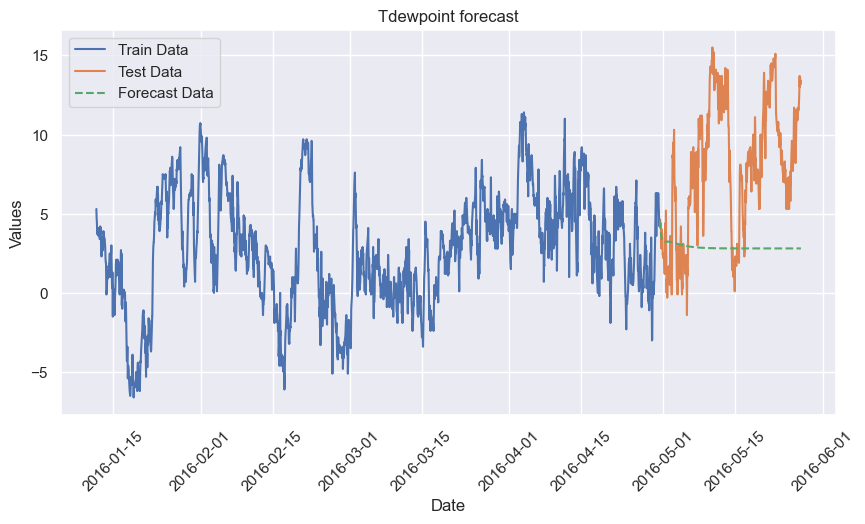

In [46]:
# plot and compare the forecast foe each columns 
for c in sub_df.columns:
    plt.figure(figsize=(10, 5))
    
    # Plot train data
    plt.plot(train_df.index, train_df[c], label='Train Data')
    
    # Plot test data
    plt.plot(test_df.index, test_df[c], label='Test Data')
    
    # Plot forecast data
    plt.plot(df_forecast.index, df_forecast[c], label='Forecast Data', linestyle='--')
    
    plt.title(c +' forecast')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

#### Evaluation metrics*

    In time series forecasting, to evaluate the models, a comprehensive evaluation criterion is essential to measure the performance of the model. Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), Mean Squared Error (MSE) and Mean Absolute Percentage Error (MAPE) are commonly used metrics to reliably evaluate the performance of the models.

- RMSE is that it penalizes large errors and scales the scores in the same units as the forecast values.
- MSE is the squared form of RMSE and is commonly used as a regression loss function.
- MAE generally, outperforms RMSE for measuring an average model accuracy.
- MAPE is the average of absolute percentage errors which is popular in the industry since it is scale-independent and easy to interpret.

*from https://towardsdatascience.com/vector-auto-regression-for-multivariate-time-series-forecasting-cf5216c9ce23

In [47]:
# Calculate evaluation metrics
rmse, mae, mse, mape = [], [], [], []
for c in sub_df.columns:
    rmse.append(root_mean_squared_error(test_df[c], df_forecast[c]) )
    mae.append(mean_absolute_error(test_df[c], df_forecast[c]) )
    mse.append(mean_squared_error(test_df[c], df_forecast[c]) )
    mape.append(mean_absolute_percentage_error(test_df[c], df_forecast[c]) )

metrics_df = pd.DataFrame({"RMSE":rmse, "MAE": mae, "MSE":mse, "MAPE":mape}, index=sub_df.columns).T
metrics_df.round(4)

Appliances        lights    T_out    RH_out  Press_mm_hg     Windspeed  \
RMSE     90.3176  5.978900e+00   9.1098   21.4365       5.2771  2.031900e+00   
MAE      52.3258  5.029700e+00   7.8658   16.9308       4.3495  1.724800e+00   
MSE    8157.2652  3.574690e+01  82.9878  459.5239      27.8475  4.128400e+00   
MAPE      0.5956  1.681592e+16   0.5487    0.3237       0.0058  4.860514e+12   

      Visibility     Tdewpoint  
RMSE      8.9965  6.537100e+00  
MAE       6.0767  5.532900e+00  
MSE      80.9374  4.273430e+01  
MAPE      0.2654  1.789713e+13

#### NOTE: MAPE output is non-negative floating point. The best value is 0.0. But note that bad predictions can lead to arbitrarily large MAPE values, especially if some y_true values are very close to zero.

#### MAE, MSE, RMSE output is non-negative floating point. The best value is 0.0

### Reference:

    https://github.com/xxl4tomxu98/vector-autoregressive-model-wage-inflations/blob/main/VAR-model.ipynb
    https://www.kaggle.com/code/lokeshkumarn/timeseries-multivariate
    https://medium.com/@seelcs12/multivariate-timeseries-forecasting-for-air-quality-prediction-f5bc772bc8a6
    https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/
    https://www.kaggle.com/code/ujoshi076/multivariate-time-series-analysis-using-var-model
    https://www.kaggle.com/code/ranja7/multivariate-timeseries-forecasting-var/notebook
    https://phdinds-aim.github.io/time_series_handbook/03_VectorAutoregressiveModels/03_VectorAutoregressiveMethods.html
    https://tracyrenee61.medium.com/how-i-used-statsmodels-vector-autoregression-var-to-forecast-on-multivariate-training-data-fc867eb6de8b
    https://cprosenjit.medium.com/multivariate-time-series-forecasting-using-vector-autoregression-3e5c9b85e42a
    https://medium.com/geekculture/vector-auto-regressive-var-models-for-multivariate-time-series-forecasting-106bb6f74add
    https://www.kaggle.com/code/prakharprasad/time-series-vector-autoregression
    https://goldinlocks.github.io/Multivariate-time-series-models/
    https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
    https://www.kaggle.com/code/ruchi798/a-tale-of-two-cities-analyzing-trends
    https://mlpills.dev/time-series/step-by-step-guide-to-multivariate-time-series-forecasting-with-var-models/
    https://www.geeksforgeeks.org/vector-autoregression-var-for-multivariate-time-series/
     